### SOLID: a Framework of Synergizing Optimization and Large Language Models for Intelligent Decision-Making
Authors: Yinsheng Wang, Tario You, Léonard Boussioux

In this model, we build two agents to decide an investment strategy for a portfolio of stocks.
For simplicity, we assume that the portfolio consists of 4 stocks: NVDA, GOOG, MSTR, and SMCI.
The first agent is a mean-variance optimization model. It aims to minimize the portfolio variance while achieving a target return.
The second agent is a GPT-based Language Model. Through prompt-based learning, it aims to generate a portfolio strategy that maximizes the portfolio return.
The two agents will communicate with each other to reach a consensus on the portfolio strategy, i.e., the portfolio weights for the two stocks.

#### Import necessary libraries

In [343]:
from openai import OpenAI
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv
import matplotlib.colors as mcolors
from IPython.display import display

load_dotenv()

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

api_key = os.getenv("PPLX")

# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "WMT"] # 1
# tickers = ["AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 2
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 3
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE", "V"] # 4
# tickers = ["AAPL", "MSFT", "NVDA", "GOOGL", "META", "JPM", "XOM", "UNH", "WMT", "HD", "CAT", "PLD", "NEE", "V", "AMD"] # 6% better
# tickers = ["MS", "BAC", "CVX", "PFE", "PEP", "COST", "NFLX", "INTC", "LMT", "CSCO", "AXP", "AMZN", "TMUS", "TM", "DUK"]
# tickers = ["CVX", "PFE", "NFLX", "LMT", "TM", "PLTR", "OKTA", "MAR", "MCD", "SBUX", "EBAY", "MRNA", "BHP", "TGT", "EOG"]
tickers = [
    'NVDA', 'AMD', 'MSFT', 'AAPL', 'INTC', 'PLTR',  # Technology
    'TSLA', 'AMZN', 'SBUX', 'TGT', 'NFLX', 'MCD',  # Consumer Discretionary
    'HOOD', 'BAC', 'JPM', 'MS', 'V', 'SCHW',  # Financials
    'ZG', 'PLD', 'WELL', 'SPG', 'PSA', 'EQR',  # Real Estate
    'GEV', 'XOM', 'DUK', 'NEE', 'EOG', 'SLB',  # Energy
    'TEM', 'UNH', 'PFE', 'MRNA', 'ABBV', 'MDT',  # Healthcare
    'CAT', 'BA', 'LMT', 'DE', 'GD', 'HON',  # Industrials
    'PCT', 'NEM', 'LIN', 'APD', 'FCX', 'MLM',  # Materials
    'GOOG', 'TMUS', 'META', 'DIS', 'VZ', 'CMCSA',  # Communication Services
    'COST', 'PEP', 'WMT', 'KO', 'PG', 'MO'  # Consumer Staples
]

stock_categories = [
    "Technology",
    "Consumer Discretionary",
    "Finance",
    "Real Estate",
    "Energy", 
    "Healthcare",
    "Industrial",
    "Material",
    "Communication",
    "Consumer Staples"
]

In [344]:
# CHANGE THESE!!
appendage = "nvda60_sparse"
iteration = "7"

# always just appends
init_news_path = f"assets/init_news_reports.json"
stock_data_path = f"assets/stock_data.json"

pft_path = f"assets/portfolio_{appendage}.csv"
stock_price_history_image_path = f'figures/stock_price_history_{appendage}.png'

grid_image_path = f'assets/output_{appendage}_{iteration}.png'
weights_coord_path = f"assets/weights_coord_{appendage}_{iteration}.json"
weights_coord_sparse_path = f"assets/weights_coord_sparse_{appendage}_{iteration}.json"
weights_llm_path = f"assets/weights_llm_{appendage}_{iteration}.json"
weights_llm_sparse_path = f"assets/weights_llm_sparse_{appendage}_{iteration}.json"
weights_opt_path = f"assets/weights_opt_{appendage}_{iteration}"
pft_value_over_time_path = f'figures/pft_value_over_time_{appendage}_{iteration}.png'
heatmap_path = f"figures/heatmap_{appendage}_{iteration}.png"
heatmap_all_path = f"figures/heatmap_all_{appendage}_{iteration}.png"
directory_path = f"assets/indiv/{appendage}_{iteration}"
directory_path_sparse = f"assets/indiv/{appendage}_{iteration}_sparse"
pnl_path = f"figures/pnl_{appendage}_{iteration}.png"

rerun_llm, rerun_opt, rerun_coord, rerun_llm_sparse, rerun_coord_sparse = True, True, True, True, True

#### Functions to save data locally

In [345]:
def save_data(data, file_path=stock_data_path):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path=stock_data_path):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

def patch_data(
    tickers,
    file_path=stock_data_path
):
    """
    Load existing data from file_path, then patch each month's dictionary
    to include 'MSTR' and 'SMCI' using Perplexity.ai's OpenAI-like client calls.
    Finally, save the patched data back to file_path.
    """

    # 1) Load the existing data
    data = load_data(file_path)

    # 2) Set up your client, months, system prompt, etc.
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")

    months = [
        "January", "Febuary", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    
    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] (I'll provide you the stock ticker) from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }

    # 3) Patch each month's dictionary if tickers dont exist
    for i, monthly_data in enumerate(data):
        for j in tqdm(range(len(tickers))):
            ticker = tickers[j]
            if ticker not in monthly_data:
                # Build the request messages for the missing ticker
                messages = [
                    system_prompt,
                    {
                        "role": "user",
                        "content": f"What happened to {ticker} in {months[i]} 2024?"
                    }
                ]

                # Make the API call
                response = client.chat.completions.create(
                    model="llama-3.1-sonar-large-128k-online",
                    messages=messages,
                )

                # Save the result in the monthly dictionary
                monthly_data[ticker] = {"news": response.choices[0].message.content}
                # print(f'patched: month {months[i]}\t{ticker}')
            # else:
                # print(f'skipping: {ticker}')
            
            # save_data(data, file_path)

    # 4) Save the patched data back to the JSON file
    save_data(data, file_path)

#### Using Perplexity to gather news about the tickers

In [346]:
client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data = [
    # Jan
    # {
    #     "MSFT":{
    #         "news": "yay", # news for all of Jan
    #         "price": 20 # last day's closing price - Jan 31
    #     }
    # }
]

#### Loading the S&P 500 tickers

In [347]:
file_path = 'assets/constituents.csv'
data = pd.read_csv(file_path)
constituents = data['Symbol'].tolist()

# constituents

#### Patching data for tickers

In [348]:
patch_data(tickers)
# S&P 500: patch_data(constituents)

Data loaded from assets/stock_data.json


100%|██████████| 60/60 [00:00<00:00, 1997287.62it/s]

Data saved to assets/stock_data.json


#### Initial stock introductions

In [349]:
def load_init_news_reports():
    with open("assets/init_news_reports.json", "r") as f:
        stock_reports = json.load(f)
    return stock_reports

def save_init_news_reports(init_news_reports):
    with open("assets/init_news_reports.json", "w") as f:
        json.dump(init_news_reports, f, indent=4)

def patch_init_news_reports():
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
    
    init_news_reports = load_init_news_reports()
    for ticker in tickers:
        if ticker not in init_news_reports:

            messages = [
                {
                    "role": "system",
                    "content": "You analyze and summarize companies."
                },
                {
                    "role": "user",
                    "content": f"Give me a 100 word summary about the stock ticker {ticker}"
                }
            ]

            response = client.chat.completions.create(
                model="llama-3.1-sonar-large-128k-online",
                messages=messages,
            ) 

            init_news_reports[ticker] = response.choices[0].message.content

    save_init_news_reports(init_news_reports)

patch_init_news_reports()

#### Get ticker prices

In [350]:
def get_last_trading_day_of_month(year, month, exchange='NYSE'):
    # Create a calendar for the specified exchange
    calendar = mcal.get_calendar(exchange)
    
    # Get the last day of the specified month
    if month == 12:
        last_day = datetime.datetime(year + 1, 1, 1) - datetime.timedelta(days=1)
    else:
        last_day = datetime.datetime(year, month + 1, 1) - datetime.timedelta(days=1)
    
    # Get the schedule for the month
    schedule = calendar.schedule(start_date=f"{year}-{month:02d}-01", end_date=last_day)
    
    # If the schedule is empty, there were no trading days this month
    if schedule.empty:
        return None
    
    # Return the last trading day
    return schedule.index[-1].date().day

def get_stock_price(tickers, date):
    prices = yf.download(tickers, start=date, end=date + datetime.timedelta(days=1))
    prices = prices["Adj Close"].dropna(how="all")
    prices = prices.values.tolist()
    return prices[0]

def get_closing_prices(data_loaded):
    year = 2024
    for month in range(1, 13):
        date = get_last_trading_day_of_month(year, month)
        datetime_obj = datetime.datetime(year, month, date)
        
        missing_tickers = []
        missing_indices = []
        for i, ticker in enumerate(tickers):
            ticker_data = data_loaded[month-1][ticker]
            if "price" not in ticker_data:
                missing_tickers.append(ticker)
                missing_indices.append(i)
            else:
                if np.isnan(ticker_data['price']):
                    missing_tickers.append(ticker)
                    missing_indices.append(i)

        if missing_indices:
            prices = get_stock_price(missing_tickers, datetime_obj)
            if type(prices) != type([]):
                prices = [prices]

            for i, (ticker, j) in enumerate(zip(missing_tickers, missing_indices)):
                data_loaded[month-1][ticker]['price'] = prices[i]

    save_data(data_loaded)

# get_stock_price('ZG', datetime.datetime(2024, 1, get_last_trading_day_of_month(2024, 1)))

data_loaded = load_data()
get_closing_prices(data_loaded)

Data loaded from assets/stock_data.json
Data saved to assets/stock_data.json


#### Getting the tickers' historical prices for the optimizer
This is not just closing price at the end of each month like above, it's the entire data for a year

In [351]:
leo_key = os.getenv("CHAT")

client = OpenAI(
    api_key=leo_key,
)

def get_stock_price(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime.today().date()

portfolio = get_stock_price(tickers, start_date, end_date)
portfolio.to_csv(pft_path, index=True)
portfolio = pd.read_csv(pft_path, parse_dates=True, index_col="Date")

[*********************100%%**********************]  60 of 60 completed


#### Historical ticker prices

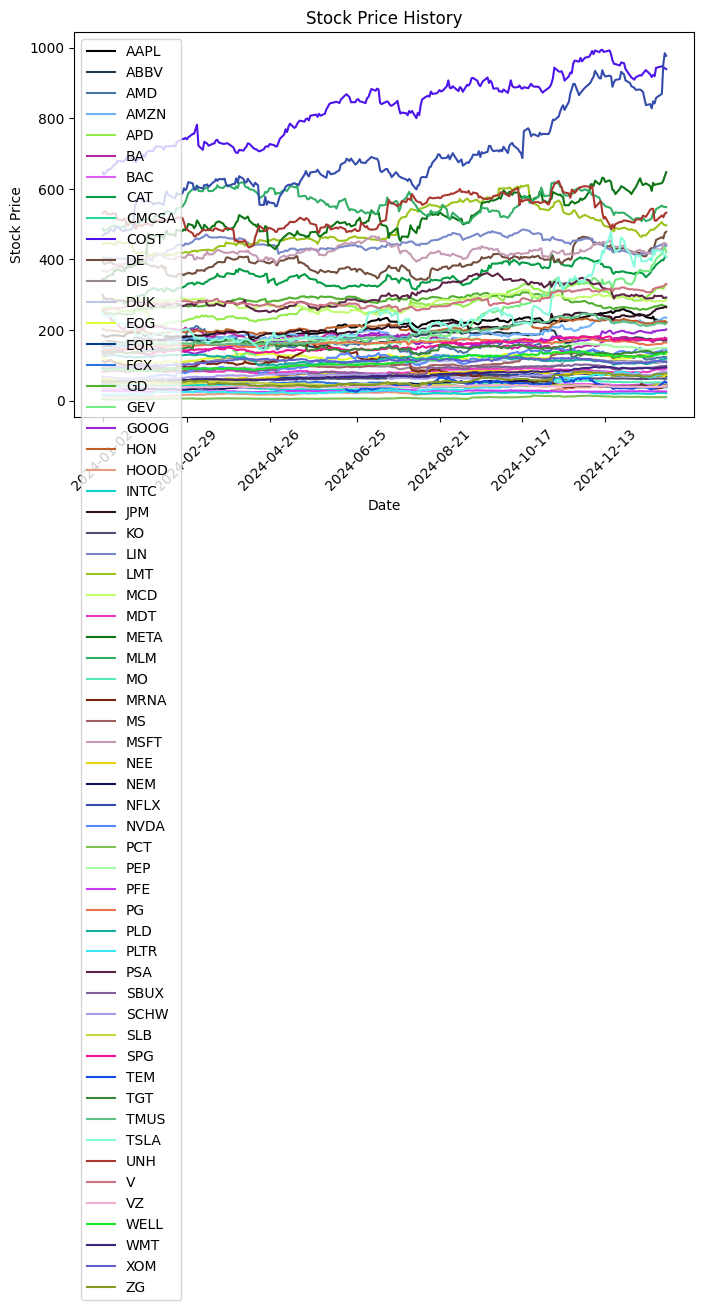

In [352]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

df = portfolio

# Function to generate a list of colors by iterating through RGB values
def generate_colors(n_colors):
    colors = []
    for i in range(n_colors):
        r = (i * 37) % 256 / 255.0  # Example formula for varying red
        g = (i * 59) % 256 / 255.0  # Example formula for varying green
        b = (i * 83) % 256 / 255.0  # Example formula for varying blue
        colors.append((r, g, b))
    return colors

# Generate unique colors based on the number of columns
colors = generate_colors(len(df.columns))

# Plot
plt.figure(figsize=(8, 5))

# Plot each column with a unique color
for idx, column in enumerate(df.columns):
    plt.plot(df.index, df[column], label=column, color=colors[idx])

# Formatting the x-axis
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price History")
plt.legend()

tick_indices = df.index[::40]  # Select every 60th index
plt.xticks(tick_indices, [date.strftime('%Y-%m-%d') for date in tick_indices], rotation=45)

plt.tight_layout()

# Save the plot
plt.savefig(stock_price_history_image_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()


Expected annual return: 42.3%
Annual volatility: 14.8%
Sharpe Ratio: 2.72


AAPL     0.209882
ABBV     0.122885
AMD      0.538987
AMZN     0.363156
APD      0.210765
BA       0.287585
BAC      0.319818
CAT      0.394472
CMCSA    0.232714
COST     0.204772
DE       0.274467
DIS      0.223500
DUK      0.106381
EOG      0.166315
EQR      0.236297
FCX      0.393035
GD       0.195502
GEV      0.600713
GOOG     0.281024
HON      0.212025
HOOD     0.846959
INTC     0.667283
JPM      0.310448
KO       0.070717
LIN      0.185694
LMT      0.084990
MCD      0.156528
MDT      0.185626
META     0.302766
MLM      0.331990
MO       0.103035
MRNA     0.540504
MS       0.391624
MSFT     0.254071
NEE      0.195463
NEM      0.302259
NFLX     0.286095
NVDA     0.473989
PCT      0.806595
PEP      0.074865
PFE      0.168035
PG       0.059171
PLD      0.338321
PLTR     0.728021
PSA      0.242370
SBUX     0.292038
SCHW     0.260732
SLB      0.298451
SPG      0.299931
TEM      1.788213
TGT      0.269054
TMUS     0.127078
TSLA     0.716151
UNH      0.132592
V        0.203323
VZ       0

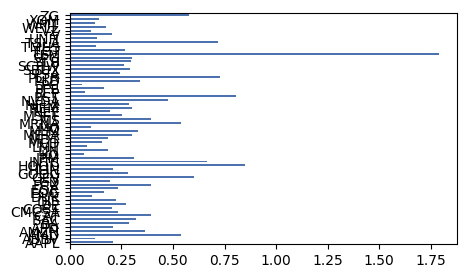

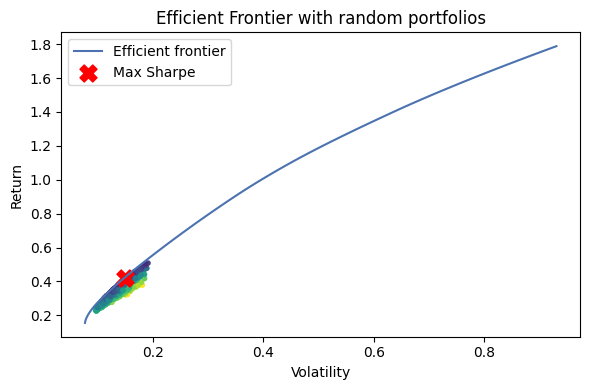

In [353]:
sample_cov = risk_models.sample_cov(portfolio, frequency=252)

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
mu = expected_returns.capm_return(portfolio)

mu.plot.barh(figsize=(5, 3))

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(6, 4))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()

mu

#### Generate initial stock info

In [354]:
with open(init_news_path, "r") as f:
    stock_reports = json.load(f)
stock_reports

{'NVDA': "NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.",
 'GOOG': "Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mountain View, California. The company's primary revenue 

In [355]:
# brief stock introductions obtained from Perplexity.ai
def generate_data_summary(reports):
    summary = f"Recent reports indicate:\n"
    for ticker in tickers:
        report = reports[ticker]
        summary += f"For {ticker}:\n{report}\n\n"
    return summary

initial_stock_info = generate_data_summary(stock_reports)

#### Dynamic YF stock data storage
pre download the data

In [356]:
# get the data
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2025, 1, 1)
prices = yf.download(tickers, start=start_date, end=end_date)
portfolio = prices["Adj Close"].dropna(how="all")
portfolio.to_csv(pft_path, index=True)

[*********************100%%**********************]  60 of 60 completed


In [357]:
# demonstration of the data being got
portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
start_date = datetime.datetime(2023, 12, 1)
end_date = datetime.datetime(2023, 12, get_last_trading_day_of_month(2023, 12))
df_subset = portfolio.loc[start_date:end_date]
df_subset

,AAPL,ABBV,AMD,AMZN,APD,BA,BAC,CAT,CMCSA,COST,DE,DIS,DUK,EOG,EQR,FCX,GD,GEV,GOOG,HON,HOOD,INTC,JPM,KO,LIN,LMT,MCD,MDT,META,MLM,MO,MRNA,MS,MSFT,NEE,NEM,NFLX,NVDA,PCT,PEP,PFE,PG,PLD,PLTR,PSA,SBUX,SCHW,SLB,SPG,TEM,TGT,TMUS,TSLA,UNH,V,VZ,WELL,WMT,XOM,ZG
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-01,190.307693,137.060013,121.389999,147.029999,263.875153,233.869995,30.191700,251.783859,40.636677,579.607544,362.007568,91.450264,89.005692,117.740883,55.721302,38.601406,243.451187,NaN,132.842697,193.644836,9.32,43.161942,152.395035,56.902119,406.739136,437.944641,279.194153,77.369766,323.583954,464.845337,38.324417,79.830002,78.047150,371.730255,57.495758,40.197464,465.739990,46.747627,4.630,163.455673,26.801525,148.049026,113.803802,20.270000,253.026291,96.678329,62.238167,50.857098,120.769417,NaN,130.896713,150.036591,238.830002,538.725220,254.504669,35.540035,87.397293,50.649212,99.592743,41.650002
2023-12-04,188.506485,137.767242,118.570000,144.839996,261.465179,234.869995,30.055176,249.812790,41.474258,582.358521,362.125366,90.887207,89.092163,117.169327,55.864079,36.997929,245.908218,NaN,130.162323,194.212708,9.55,41.790310,153.512466,56.834190,401.740112,439.191986,279.360077,77.147308,318.802216,461.742065,38.234455,79.870003,78.355911,366.400085,57.009903,39.553528,453.899994,45.493099,4.650,163.891693,27.144541,147.467148,115.795815,18.400000,256.165344,95.119003,61.725754,50.507633,122.672539,NaN,129.857544,150.578583,235.580002,539.828003,252.509888,35.042583,87.748993,50.636086,99.051224,42.330002
2023-12-05,192.477051,138.168655,118.379997,146.880005,253.596542,234.160004,29.821131,250.244278,40.059048,588.453430,354.479095,89.682106,88.842369,116.169106,55.445267,35.974857,244.621201,NaN,131.916016,192.832184,10.53,41.365990,153.493011,56.921524,399.102234,434.855499,279.760406,76.238083,317.078796,456.788757,38.297428,78.279999,77.352455,369.755005,56.582355,38.919338,455.149994,46.552803,3.990,162.728928,26.968395,142.327240,114.179115,18.299999,255.718201,93.111374,61.321739,49.366383,122.606918,NaN,129.051453,151.761139,238.720001,541.777405,252.678604,35.392635,87.807610,51.105358,97.126862,42.520000
2023-12-06,191.382416,139.898499,116.820000,144.520004,252.880371,236.889999,29.772371,251.009140,40.136066,590.475464,358.797913,90.383430,90.254692,114.073395,55.464306,35.660061,245.654694,NaN,130.959427,193.654602,11.27,40.724583,151.880051,56.863300,395.486389,437.944641,280.072815,76.450890,316.241974,458.012146,37.208874,80.599998,76.619164,366.062622,58.496613,38.724205,446.730011,45.490101,4.120,162.312271,26.690277,142.220551,114.564041,17.129999,256.507782,94.553749,61.252758,47.922752,123.497551,NaN,129.537064,153.239334,239.369995,541.058716,252.361038,35.466335,85.404327,50.550762,95.840736,43.490002
2023-12-07,193.322922,141.418091,128.369995,146.880005,253.586914,237.330002,29.899145,252.421249,40.598175,593.897217,354.557617,91.223068,90.754295,112.739754,55.873600,35.778111,245.206192,NaN,137.954315,193.654602,11.48,41.592957,152.346451,56.999157,393.846344,435.703339,280.004486,76.944176,325.347168,462.836121,37.172882,79.949997,77.526131,368.196655,58.156517,38.763233,452.000000,46.582794,4.660,162.263809,26.541943,142.075089,114.467804,17.219999,259.770477,93.988487,62.041080,47.269211,124.943420,NaN,131.294891,154.086853,242.639999,539.818237,253.879440,35.604519,85.492256,50.218075,95.173492,45.009998
2023-12-08,194.755875,142.670090,128.919998,147.419998,254.806366,244.699997,30.191700,254.470749,40.530785,593.732056,356.962372,91.986145,90.687042,113.320847,55.987823,37.529140,245.986206,NaN,136.150787,190.541107,11.73,42.135685,154.027420,56.873005,396.434784,436.590088,278.774323,76.750717,331.483734,466.874390,37.154888,80.320000,79.388298,371.452332,58.010769,38.129047,453.760010,47.492535,5.030,160.539032,26.681005,140.765854,115.333893,17.770000,260.455383,94.154175,63.134884,47.600857,126.398773,NaN,131.294891,154.126251,243.839996,541.295105,253.800034,35.23

#### Main class to integrate the LLM with the Portfolio Optimization model

In [358]:
class bcolors:
    PURPLE = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    ENDC = '\033[0m'

In [363]:
class CoordinationFramework():
    def __init__(self, mu, Q, target_return, penalty=1, iteration=2, verbose=False):
        """
        Initialization of the class for coordination framework
        :param np.array mu: expected return of the stocks
        :param np.array Q: covariance matrix of the stocks
        :param float target_return: target return of the portfolio
        :param float penalty: penalty term in coordination algorithm
        :param float iteration: number of iteration of coordination algorithm
        """
        # Store the init params so we can restore them later
        self._init_mu = mu
        self._init_Q = Q
        self._init_target_return = target_return
        self._init_penalty = penalty
        self._init_iteration = iteration
        self._init_verbose = verbose

        # Now do the usual initialization
        self.mu = mu  # expected return
        self.Q = Q.to_numpy()  # covariance matrix
        self.n = len(mu)  # number of stocks
        self.target_return = target_return

        self.penalty = penalty
        self.iteration = iteration
        self.verbose = verbose

        # initialization
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    def reset_variables(self):
        """
        Reset all variables to their initial values, exactly as they were in __init__.
        """
        # Restore parameters
        self.mu = self._init_mu
        self.Q = self._init_Q.to_numpy()  
        self.n = len(self._init_mu)
        self.target_return = self._init_target_return

        self.penalty = self._init_penalty
        self.iteration = self._init_iteration
        self.verbose = self._init_verbose

        # Reinitialize mutable state variables
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    # In this function, the optimization model will update their preferred portfolio weights.
    def PortfolioOptimization_Agent(self, current_plan, verbose=False):
        # previous opt
        self.model = Model("mean_variance_optimization")
        self.model.setParam('OutputFlag', 0)
        # Add variables
        x = {}
        for i in range(self.n):
            x[i] = self.model.addVar(
                vtype=GRB.CONTINUOUS, name="x_{}".format(i))

        # Set objective
        obj = quicksum(self.Q[i, j] * x[i] * x[j]
                       for i in range(self.n) for j in range(self.n))
        dual = quicksum(
            self.optimization_price[i] * x[i] for i in range(self.n))
        penalty = self.penalty * \
            quicksum((x[i] - current_plan[i]) * (x[i] - current_plan[i])
                     for i in range(self.n))
        self.model.setObjective(obj + dual + penalty, GRB.MINIMIZE)

        # Add constraints
        self.model.addConstr(quicksum(x[i] for i in range(
            self.n)) == 1, "budget")  # budget constraint
        self.model.addConstr(quicksum(self.mu[i] * x[i] for i in range(
            self.n)) >= self.target_return, "target_return")  # target return constraint
        self.model.optimize()

        if verbose:
            print("\n[DEBUG] Building model with:")
            print(f"[DEBUG]   mu: {self.mu}")
            print(f"[DEBUG]   Q: {self.Q}")
            print(f"[DEBUG]   target_return: {self.target_return}")
            print("[DEBUG]   current_plan:", current_plan)
            print("[DEBUG]   optimization_price:", self.optimization_price)
            print("[DEBUG]   penalty:", self.penalty)
            print("[DEBUG]   x:", x)
            print("[DEBUG]   n:", self.n)
            
            self.model.write("debug/debug_model.lp")

            status = self.model.status
            print(f"[DEBUG] Gurobi optimization status: {status}")


        # Get results for portfolio weight on first stock
        weights = [x[i].x for i in range(self.n)]

        return weights

    def response_format(self):
        prompt = "please write your final recommendation in a single line, in the format below:\n\n"

        # Construct the label format dynamically based on the number of tickers.
        # Example of final output:  "AAPL: X1, MSFT: X2, AMZN: X3. Replace X1, X2, X3..."
        prompt += ", ".join([f"{ticker}: X{i+1}" for i, ticker in enumerate(tickers)])
        prompt += (
            ".\n\nReplace "
        )

        # Remind the model to replace placeholders with the actual confidence levels.
        prompt += ", ".join([f"X{i+1}" for i in range(len(tickers))])
        prompt += (
            " with the confidence level for each stock."
        )

        return prompt

    # In this function, the language model take the prompt as input and generate the preferred portfolio weights.
    def LLM_Agent(self, month_data, consensus_plan, month, iter, sparse, pure=False, verbose=False):
        system_prompt = """You are collaborating with an optimization model to develop an optimal portfolio strategy. The optimization model is an expert in numerical calculations and historical trend analysis, ensuring precision in minimizing risk and achieving target returns. Your role is to bring contextual understanding, strategic insights, and adaptability to the process.\nWhile you are encouraged to bring your unique perspective, remember:\n1. The optimization model has consistently outperformed by a significant margin (10-20%). Therefore, where substantial differences arise, you must carefully review the optimizer's proposal and adjust your recommendations unless you have a strong, data-backed reason to maintain your position.\n2. In this collaboration, flexibility and compromise are critical. Adapt your strategy when the optimizer provides strong evidence, as rigid decision-making has been shown to lead to suboptimal results.\n3. Your goal is to work synergistically with the optimizer to maximize overall portfolio performance. This requires understanding and integrating the optimizer's proposals to improve alignment.\n4. If you disagree, explicitly identify the key aspects of the optimizer's proposal that you are willing to accept or adjust. Never reject the optimizer's strategy outright—focus on making incremental refinements."""
        if pure:
            system_prompt = "You're a very advanced stock trading expert with a deep understanding in the politics, economics, and business of companies in relation to their stock performance. When you see a news, you will know whether or not it will have a strong impact on your trader planning the next move of investment decisions. You always maximize the profit through your stock investments."
        messages = [
            {"role": "system", "content": system_prompt},
        ]
        messages.extend(self.conversation_history)

        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------
        current_prompt = ""

        if iter == 0:
            # Optionally include any initial stock info if this is the very first iteration.
            current_prompt += (
                f"{initial_stock_info}\n\n"
            )

        # summarize conversations for previous months
        # for 60 stocks, exceeds 128k tokens
        # if month != 0 and len(self.conversation_summaries) != 0:
        #     current_prompt += "Here is what happened in the last few months for you to gain a background understanding of what happened:\n"
        #     current_prompt += "\n".join(self.conversation_summaries)
        #     current_prompt += "\n\n"

        if iter == 0:
            stock_prices = f"The stock prices today are:\n"
            for i, ticker in enumerate(tickers):
                ticker_close = month_data[ticker]['price']
                stock_prices += f"{ticker} = {ticker_close}"
                if i != len(tickers) - 1:
                    stock_prices += ", "
            stock_prices += "\n"

            stock_news = ""
            for ticker in tickers:
                ticker_news = month_data[ticker]['news']
                stock_news += f"news for {ticker}:\n{ticker_news}\n\n"

            # If this is the first iteration in a given month, include relevant news and price info.
            current_prompt += (
                "Please read the following information carefully.\n\n"
                f"---\n**Stock News**\n\n{stock_news}\n\n"
                f"---\n**Recent Stock Prices**\n\n{stock_prices}\n\n"
            )

        # Begin the main decision instructions.
        current_prompt += (
            "You are a trader responsible for making portfolio allocation decisions. "
            # "Use all relevant information provided (such as any past decisions, news, or stock data) to "
            "Use all relevant information provided (such as news and stock data) to "
            "decide how much to invest in each stock.\n\n"
            "Think about:\n"
            "1. Any news articles and how they might affect each stock.\n"
            # "2. Any patterns in recent price movements.\n"
            "2. Previous decisions you have made regarding portfolio weights.\n"
        )

        # If we're past the first iteration, include guidance about consensus plans.
        if iter != 0 and self.current_plan != [0.0] * self.n and not pure:
            current_prompt += (
                "Also, you are working with a optimization model that is very proficient in numerical calculations, and here is the current plan (portfolio allocation) you guys have worked" "out. Decided if you agree with this plan, then make the necessary adjustments to your own plan: "
                f"{self.current_plan}\n\n"
            )

        current_prompt += (
            f"Also, here is the decision-price of your plan thus far: {self.LLM_price}."
            "A higher decision-price means you should adjust your plan to be higher. And a negative decision-price means you should adjust your plan to be smaller."
        )

        # Ask the model for a recommendation. Emphasize the requirement to explain reasoning first, then provide the format.
        current_prompt += (
            "### Task\n"
            "1. Carefully evaluate the optimizer's proposed portfolio weights and explain your reasoning for agreement or disagreement. When in doubt, lean towards collaboration by adjusting your recommendations closer to the optimizer's.\n"
            "2. Finalize your recommendation in the following format: [Ticker: Confidence Level]:\n"
            "   - Very Low Confidence\n"
            "   - Low Confidence\n"
            "   - Somewhat Low Confidence\n"
            "   - Neutral\n"
            "   - Somewhat High Confidence\n"
            "   - High Confidence\n"
            "   - Very High Confidence\n\n"
            "3. Conclude by summarizing how your proposal aligns with the optimizer's and why it contributes to achieving the collective goals.\n"
            "Even if you are unsure, you **must** provide the best decision you can based on the available information.\n\n"
            "Take a deep breath and work on this problem step-by-step.\n")
        
        if sparse:
            current_prompt += (
                "IMPORTANT: Aim for *sparsity* in your portfolio. Identify a smaller subset of stocks you have high conviction in, "
                "and invest heavily in those. Assign very low (or zero) weight to the rest. "
                "Please avoid spreading small amounts across many stocks unless there's a compelling reason to do so.\n\n"
            )

        current_prompt += (    "### Response Format\n"
            "After your explanation, " + self.response_format() + ""
            "\nRemember, collaboration, adaptability, and performance are key to success."
        )

        
        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------


        if verbose:
            print(f"\n# month {month} iter {iter}")
            # print(f"prompt: \n{current_prompt}\n")

        messages.append({"role": "user", "content": current_prompt})

        result_dict = []
        retry_messages = [m for m in messages]
        attempt = 0
        retry = True
        retry_reason = ""
        missing_tickers = set(tickers)
        result_dict = {}
        while retry:
            if attempt != 0:
                if retry_reason == "INVALID FORMAT":
                    new_message = "Sorry, I could not parse your response. Please try again with the correct specified formatting: " + self.response_format()

                    missing_tickers = set(tickers)
                elif retry_reason == "ZERO SUM":
                    new_message = "The sum of the weights for each stock cannot be 0. Please try again: " + self.response_format()
                    
                    missing_tickers = set(tickers)
                else: # "MISSING TICKER"
                    new_message = f"You missed a few tickers: {missing_tickers}. Give the confidence levels for them: "

                retry_messages.append({
                    "role": "user", 
                    "content": new_message
                })

                if verbose:
                    print(f"\n# month {month} iter {iter} {bcolors.RED}RETRY{bcolors.ENDC} because {retry_reason}") # PROMPT: \n{new_message}\n

            attempt += 1
            # Make an API call to ChatGPT with the prompt
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=retry_messages,
                temperature=0
            )

            # Parse the decision from the response
            text = response.choices[0].message.content
            retry_messages.append({
                "role": "assistant",
                "content": text
            })

            if verbose:
                print(f"{bcolors.PURPLE}[DEBUG]{bcolors.ENDC}\tChat reponse: {text}")

            CONFIDENCE_LEVELS = {
                "Very High": 0.6,
                "High": 0.5,
                "Somewhat High": 0.4,
                "Neutral": 0.3,
                "Somewhat Low": 0.2,
                "Low": 0.1,
                "Very Low": 0.0
            }

            # Create regex pattern from confidence levels
            pattern = "|".join(CONFIDENCE_LEVELS.keys())

            original_missing_tickers = missing_tickers.copy()
            for stock in original_missing_tickers:
                # Use word boundary \b to ensure exact stock matches
                match = re.search(
                    fr'\b{stock}\b.*?:\s*({pattern})',
                    text,
                    re.IGNORECASE
                )

                if match:
                    confidence = match.group(1).title()
                    result_dict[stock] = CONFIDENCE_LEVELS[confidence]
                    missing_tickers.remove(stock)
                else:
                    retry = True
                    if verbose:
                        print(f"[DEBUG]\tCouldn't fetch {stock}.")

            retry = False

            if result_dict == {}:
                if verbose:
                    print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tInvalid format: could not find tickers, retrying.")
                retry = True
                retry_reason = "INVALID FORMAT"
                continue

            if sum(result_dict.values()) == 0:
                if verbose: 
                    print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tInvalid output: sum = 0")
                retry = True
                retry_reason = "ZERO SUM"
                continue

            if len(missing_tickers) != 0:
                print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tmissing {missing_tickers = }")
                retry = True
                retry_reason = "MISSING TICKER"
                continue

            if verbose:
                print(f"{bcolors.GREEN}[DEBUG]{bcolors.ENDC}\tfetched weights: {result_dict = }")
                retry = False

        # normalize sum to 1
        norm_factor = 1/sum(result_dict.values())
        result_dict = {k: v * norm_factor for k, v in result_dict.items()}
        result_dict = [r for r in result_dict.values()]


        self.conversation_history.append(
            {"role": "user", "content": current_prompt})
        self.conversation_history.append(
            {"role": "assistant", "content": text})

        norm_factor = 1/sum(result_dict)
        normalized_weights = [norm_factor * w for w in result_dict]

        return normalized_weights

    # update the consensus plan and activity price for the next iteration
    def update_plan(self, plan1, price1, plan2, price2):
        result = []
        # plan1 = [p for p in plan1.values()] # if using dict with tickers
        # plan2 = [p for p in plan2.values()]

        for p1, p2, pr1, pr2 in zip(plan1, plan2, price1, price2):
            average_plan = (p1 + p2) / 2
            average_price = (pr1 + pr2) / 2
            result.append(max(0, average_price / self.penalty + average_plan))
        return result

    def update_activity_price(self, current_activity_price, current_plan, new_plan):
        updated_prices = []
        
        for curr_price, curr_plan, new_plan_val in zip(current_activity_price, current_plan, new_plan):
            adjustment = self.penalty * (new_plan_val - curr_plan)
            updated_price = curr_price - adjustment
            updated_prices.append(updated_price)

        return updated_prices

    def test_convergence(self, all_llm_opt_plans):
        # if llm's plan and opt's plan do not differ by more than 5%
        try:
            plan_convergence = True
            for l in range(len(tickers)):
                if abs(all_llm_opt_plans[-1][l+len(tickers)+1] - all_llm_opt_plans[-1][l+2*len(tickers)+1]) > 1/20:
                    plan_convergence = False
                    break
            if plan_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")
        
        # if this iter's plan and last iter's plan do not differ by more than 0.2%
        # - weights have basically not changed in the past two iterations
        try:
            iter_convergence = True
            for i in range(1, len(all_llm_opt_plans[0])): 
                if abs(all_llm_opt_plans[-1][i] - all_llm_opt_plans[-2][i]) > 1/500:
                    iter_convergence = False
                    break
            if iter_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")

        return False
        
    def test_convergence_aux(self):
        max_diff = 0
        max_diff_ticker = None

        try:
            for l, ticker in enumerate(tickers):
                diff = abs(self.plan_histories[-1][l+len(tickers)+1] - self.plan_histories[-1][l+2*len(tickers)+1])
                if diff > max_diff:
                    max_diff = diff
                    max_diff_ticker = self.plan_histories[-1][0]

            print(f"[DEBUG]\tThe max diff ticker is {max_diff_ticker} with a diff of {max_diff}")
        except Exception as e:
            print(f"Error occurred: {str(e)}")


        
    def OptAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 

            prev_prev_year = prev_year if prev_month != 1 else 2023
            prev_prev_month = prev_month - 1 if prev_month != 1 else 12
            
            start_date = datetime.datetime(prev_prev_year, prev_prev_month, get_last_trading_day_of_month(prev_prev_year, prev_prev_month))
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            
            last_month_data = portfolio.loc[start_date].fillna(0)
            month_data = portfolio.loc[end_date].fillna(0)

            self.mu = expected_returns.mean_historical_return(portfolio.loc[start_date:end_date]) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio.loc[start_date:end_date]).ledoit_wolf().to_numpy()

            self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan, verbose)

            self.current_plan = self.optimization_plan
            self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
            
            self.plan_histories.append(self.optimization_plan)

        return self.plan_histories
    
    def LLMAlgorithm(self, data, sparse, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):

            self.summarize()
            
            self.conversation_history = []

            self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, 0, sparse, pure=True, verbose=verbose)
            
            self.current_plan = self.LLM_plan
            self.LLM_Price = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)
            
            self.plan_histories.append(self.LLM_plan)

        return self.plan_histories
    
    def summarize(self):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)
        messages.append({
            "role": "user",
            "content": "Please summarize everything that happened in this conversation very succinctly, extracting the key pieces of information relevant to future stock assessments, as it will be used for another intelligent agent to overview what happened this month."
        })

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0
        )
        text = response.choices[0].message.content
        self.conversation_summaries.append(text)

    # In this function, the coordination algorithm will update the preferred portfolio weights of the two agents.
    def CoordinationAlgorithm(self, data, sparse, verbose=False):
        self.reset_variables()
        
        for month, month_data in enumerate(data):

            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.summarize()

            self.conversation_history = []

            for i in range(self.iteration):
                # optimization agent get the preferred portfolio weights
                
                self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)
                # LLM agent get the preferred portfolio weights
                self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, i, sparse, verbose=verbose)

                # update the plan for the next iteration
                self.current_plan = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)

                # Coordinator update dual variable/prices
                self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
                self.LLM_price = self.update_activity_price(
                    self.LLM_price, self.LLM_plan, self.current_plan)

                self.penalty = 1 - i/self.iteration

                all_llm_opt = [f"month {month} iter {i}"] + self.current_plan + \
                    self.LLM_plan + self.optimization_plan

                self.plan_histories.append(all_llm_opt)

                columns = ['status']
                categories = ['all', 'llm', 'opt']
                for c in categories:
                    for ticker in tickers:
                        columns.append(f'{c} {ticker}')

                if self.test_convergence(self.plan_histories):

                    all_llm_opt = [f"CONVERGED month {month} iter {i}"] + self.current_plan + \
                        self.LLM_plan + self.optimization_plan
                    self.plan_histories[-1] = all_llm_opt
                    df = pd.DataFrame(self.plan_histories, columns=columns)
                    if verbose:
                        print("[DEBUG]\tConverged because {} < ")
                        print(df) # display(df)
                    break

                else: 
                    # get the largest gap 
                    self.test_convergence_aux()

                df = pd.DataFrame(self.plan_histories, columns=columns)
                if verbose:
                    print("## updated weights\n```")
                    print(df) # display(df)
                    print("\n```\n")

        return self.plan_histories

In [364]:
CoordFW = CoordinationFramework(
    mu, S, 2.6, penalty=1, iteration=20, verbose=False)
# appl15 0.93703
# morgan15 0.449055
# chev15 0.688154
# nvda60 2.6

#### Run the optimizer only, as baseline

In [365]:
if rerun_opt:
    opt_histories = CoordFW.OptAlgorithm(data_loaded)
    with open(weights_opt_path, "w") as f:
        json.dump(opt_histories, f, indent=4)

# -- OR --

with open(weights_opt_path, "r") as f:
    opt_histories = json.load(f)

opt_histories

[[0.020089467229826626,
  0.02048027069174104,
  0.011317689883914496,
  0.019576632865734498,
  0.017229991172905197,
  0.01967232037709729,
  0.013115245706776007,
  0.014251105956634104,
  0.018026286755766965,
  0.0196336021157046,
  0.013240893018724876,
  0.01584212658757685,
  0.01890498708775385,
  0.017785035793729507,
  0.015195978383630179,
  0.006048552785928873,
  0.020574848795396457,
  0.023201831831388457,
  0.021606206369090625,
  0.020342500251461632,
  0.012141178175081948,
  0.013067016544939532,
  0.019536293623105983,
  0.01974136068618801,
  0.022317091264907794,
  0.021336890617903146,
  0.020945723362717487,
  0.016196518626743688,
  0.019017944763497795,
  0.01805683196483752,
  0.0165839558605178,
  0.008435957799123268,
  0.014473845237329619,
  0.022656840868254577,
  0.014911881018420876,
  0.011649176466123247,
  0.016221071241442557,
  0.015836983627430464,
  0.0003571283247919801,
  0.019881702881879716,
  0.02551838234918638,
  0.019139188608592504,
  

#### Run the LLM only, as baseline

In [ ]:
if rerun_llm:
    llm_histories = CoordFW.LLMAlgorithm(data_loaded, False, False)
    with open(weights_llm_path, "w") as f:
        json.dump(llm_histories, f, indent=4)

if rerun_llm_sparse:
    llm_histories_sparse = CoordFW.LLMAlgorithm(data_loaded, True, False)
    with open(weights_llm_sparse_path, "w") as f:
        json.dump(llm_histories_sparse, f, indent=4)
    
# -- OR --

with open(weights_llm_path, "r") as f:
    llm_histories = json.load(f)
with open(weights_llm_sparse_path, "r") as f:
    llm_histories_sparse = json.load(f)

#### Run the coordinator algorithm

In [ ]:
if rerun_coord:
    coord_histories = CoordFW.CoordinationAlgorithm(data_loaded, False, False)
    with open(weights_coord_path, "w") as f:
        json.dump(coord_histories, f, indent=4)

if rerun_coord_sparse:
    coord_histories_sparse = CoordFW.CoordinationAlgorithm(data_loaded, True, False)
    with open(weights_coord_sparse_path, "w") as f:
        json.dump(coord_histories_sparse, f, indent=4)

# -- OR --

with open(weights_coord_path, "r") as f:
    coord_histories = json.load(f)
weights_coord = [h[1:1+len(tickers)] for h in coord_histories]

with open(weights_coord_sparse_path, "r") as f:
    coord_histories_sparse = json.load(f)
weights_coord_sparse = [h[1:1+len(tickers)] for h in coord_histories_sparse]

#### Display results

In [ ]:
columns = ['status']
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

In [232]:
df = pd.DataFrame(coord_histories, columns=columns)

# df

,status,all NVDA,all AMD,all MSFT,all AAPL,all INTC,all PLTR,all TSLA,all AMZN,all SBUX,all TGT,all NFLX,all MCD,all HOOD,all BAC,all JPM,all MS,all V,all SCHW,all ZG,all PLD,all WELL,all SPG,all PSA,all EQR,all GEV,all XOM,all DUK,all NEE,all EOG,all SLB,all TEM,all UNH,all PFE,all MRNA,all ABBV,all MDT,all CAT,all BA,all LMT,all DE,all GD,all HON,all PCT,all NEM,all LIN,all APD,all FCX,all MLM,all GOOG,all TMUS,all META,all DIS,all VZ,all CMCSA,all COST,all PEP,all WMT,all KO,all PG,all MO,llm NVDA,llm AMD,llm MSFT,llm AAPL,llm INTC,llm PLTR,llm TSLA,llm AMZN,llm SBUX,llm TGT,llm NFLX,llm MCD,llm HOOD,llm BAC,llm JPM,llm MS,llm V,llm SCHW,llm ZG,llm PLD,llm WELL,llm SPG,llm PSA,llm EQR,llm GEV,llm XOM,llm DUK,llm NEE,llm EOG,llm SLB,llm TEM,llm UNH,llm PFE,llm MRNA,llm ABBV,llm MDT,llm CAT,llm BA,llm LMT,llm DE,llm GD,llm HON,llm PCT,llm NEM,llm LIN,llm APD,llm FCX,llm MLM,llm GOOG,llm TMUS,llm META,llm DIS,llm VZ,llm CMCSA,llm COST,llm PEP,llm WMT,llm KO,llm PG,llm MO,opt NVDA,opt AMD,opt MSFT,opt AAPL,opt INTC,opt PLTR,opt TSLA,opt AMZN,opt SBUX,opt TGT,opt NFLX,opt MCD,opt HOOD,opt BAC,opt JPM,opt MS,opt V,opt SCHW,opt ZG,opt PLD,opt WELL,opt SPG,opt PSA,opt EQR,opt GEV,opt XOM,opt DUK,opt NEE,opt EOG,opt SLB,opt TEM,opt UNH,opt PFE,opt MRNA,opt ABBV,opt MDT,opt CAT,opt BA,opt LMT,opt DE,opt GD,opt HON,opt PCT,opt NEM,opt LIN,opt APD,opt FCX,opt MLM,opt GOOG,opt TMUS,opt META,opt DIS,opt VZ,opt CMCSA,opt COST,opt PEP,opt WMT,opt KO,opt PG,opt MO
0,CONVERGED month 0 iter 0,1.947022e-02,0.022086,0.017659,0.021695,2.050483e-02,0.021709,0.016009,1.910856e-02,0.018465,0.021785,0.018400,0.012478,0.014095,1.834127e-02,0.007715,0.012849,0.012690,0.021019,0.020175,0.017337,0.014682,0.008621,0.016843,1.696221e-02,0.023017,0.017775,0.022447,0.017564,0.016473,1.371547e-02,0.020249,0.016415,0.014430,1.828009e-02,0.016851,0.005854,0.017341,0.012599,5.253661e-03,0.019413,0.019313,0.016605,0.012733,0.008109,0.019946,0.015619,0.014675,0.017274,0.015390,0.023400,0.019287,0.018931,0.007725,2.052605e-02,0.017107,0.017810,1.970495e-02,0.022032,0.012827,0.012611,0.019048,0.023810,0.023810,0.023810,0.023810,0.023810,0.019048,0.023810,0.019048,0.023810,0.023810,0.009524,0.009524,0.019048,0.000000,0.019048,0.004762,0.019048,0.019048,0.014286,0.014286,0.004762,0.014286,0.014286,0.023810,0.014286,0.023810,0.019048,0.014286,0.009524,0.023810,0.023810,0.014286,0.014286,0.019048,0.000000,0.019048,0.009524,0.009524,0.019048,0.014286,0.014286,0.014286,0.009524,0.023810,0.014286,0.019048,0.019048,0.014286,0.023810,0.023810,0.014286,0.004762,0.019048,0.014286,0.014286,0.023810,0.023810,0.009524,0.019048,1.989281e-02,2.036268e-02,1.150908e-02,1.958013e-02,1.720014e-02,1.960909e-02,1.297009e-02,1.440760e-02,1.788256e-02,1.976022e-02,1.298986e-02,1.543318e-02,1.866625e-02,1.763492e-02,1.543017e-02,6.649722e-03,2.061789e-02,2.299136e-02,2.130207e-02,2.038790e-02,1.507751e-02,1.248039e-02,1.939984e-02,1.963870e-02,2.222405e-02,2.126438e-02,2.108443e-02,1.608109e-02,1.866013e-02,1.790714e-02,1.668765e-02,9.020852e-03,1.457389e-02,2.227446e-02,1.465435e-02,1.170763e-02,1.563508e-02,1.567484e-02,9.835132e-04,1.977862e-02,2.433983e-02,1.892419e-02,1.117984e-02,6.694866e-03,1.608192e-02,1.695198e-02,1.030146e-02,1.550040e-02,1.649385e-02,2.299136e-02,1.476436e-02,2.357649e-02,1.068878e-02,2.200448e-02,1.992888e-02,2.133405e-02,1.560037e-02,2.025349e-02,1.612932e-02,6.173815e-03
1,month 1 iter 0,6.999088e-03,0.023723,0.024301,0.019847,8.868310e-03,0.025782,0.017871,1.056189e-02,0.017382,0.023906,0.018794,0.014172,0.016509,1.139816e-02,0.008764,0.016956,0.012168,0.021342,0.016114,0.017000,0.005705,0.002618,0.015438,8.165499e-03,0.025120,0.019023,0.018238,0.018638,0.021171,4.801080e-03,0.021073,0.013861,0.014762,8.580536e-03,0.016962,0.007853,0.035992,0.044910,1.066882e-02,0.020270,0.017678,0.020458,0.016740,0.010472,0.019196,0.016702,0.015468,0.016772,0.013497,0.020448,0.019354,0.019312,0.011147,1.298191e-02,0.011530,0.020084,2.227415e-02,0.025727,0.010783,0.013066,0

In [ ]:
df_sparse = pd.DataFrame(coord_histories_sparse, columns=columns)

# df_sparse

In [182]:
pure_llm_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_llm_history[i].append(llm_histories[j][i])

# pure_llm_history

In [ ]:
pure_llm_history_sparse = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_llm_history_sparse[i].append(llm_histories_sparse[j][i])

# pure_llm_history_sparse

In [233]:
pure_opt_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_opt_history[i].append(opt_histories[j][i])

# pure_opt_history

In [234]:
all_columns = [col for col in df.columns if "all" in col]
df_filtered = df[df['status'].str.contains("CONVERGED")]
df_filtered.set_index('status', inplace=True)

#### Graph all results

NameError: name 'pure_llm_history' is not defined

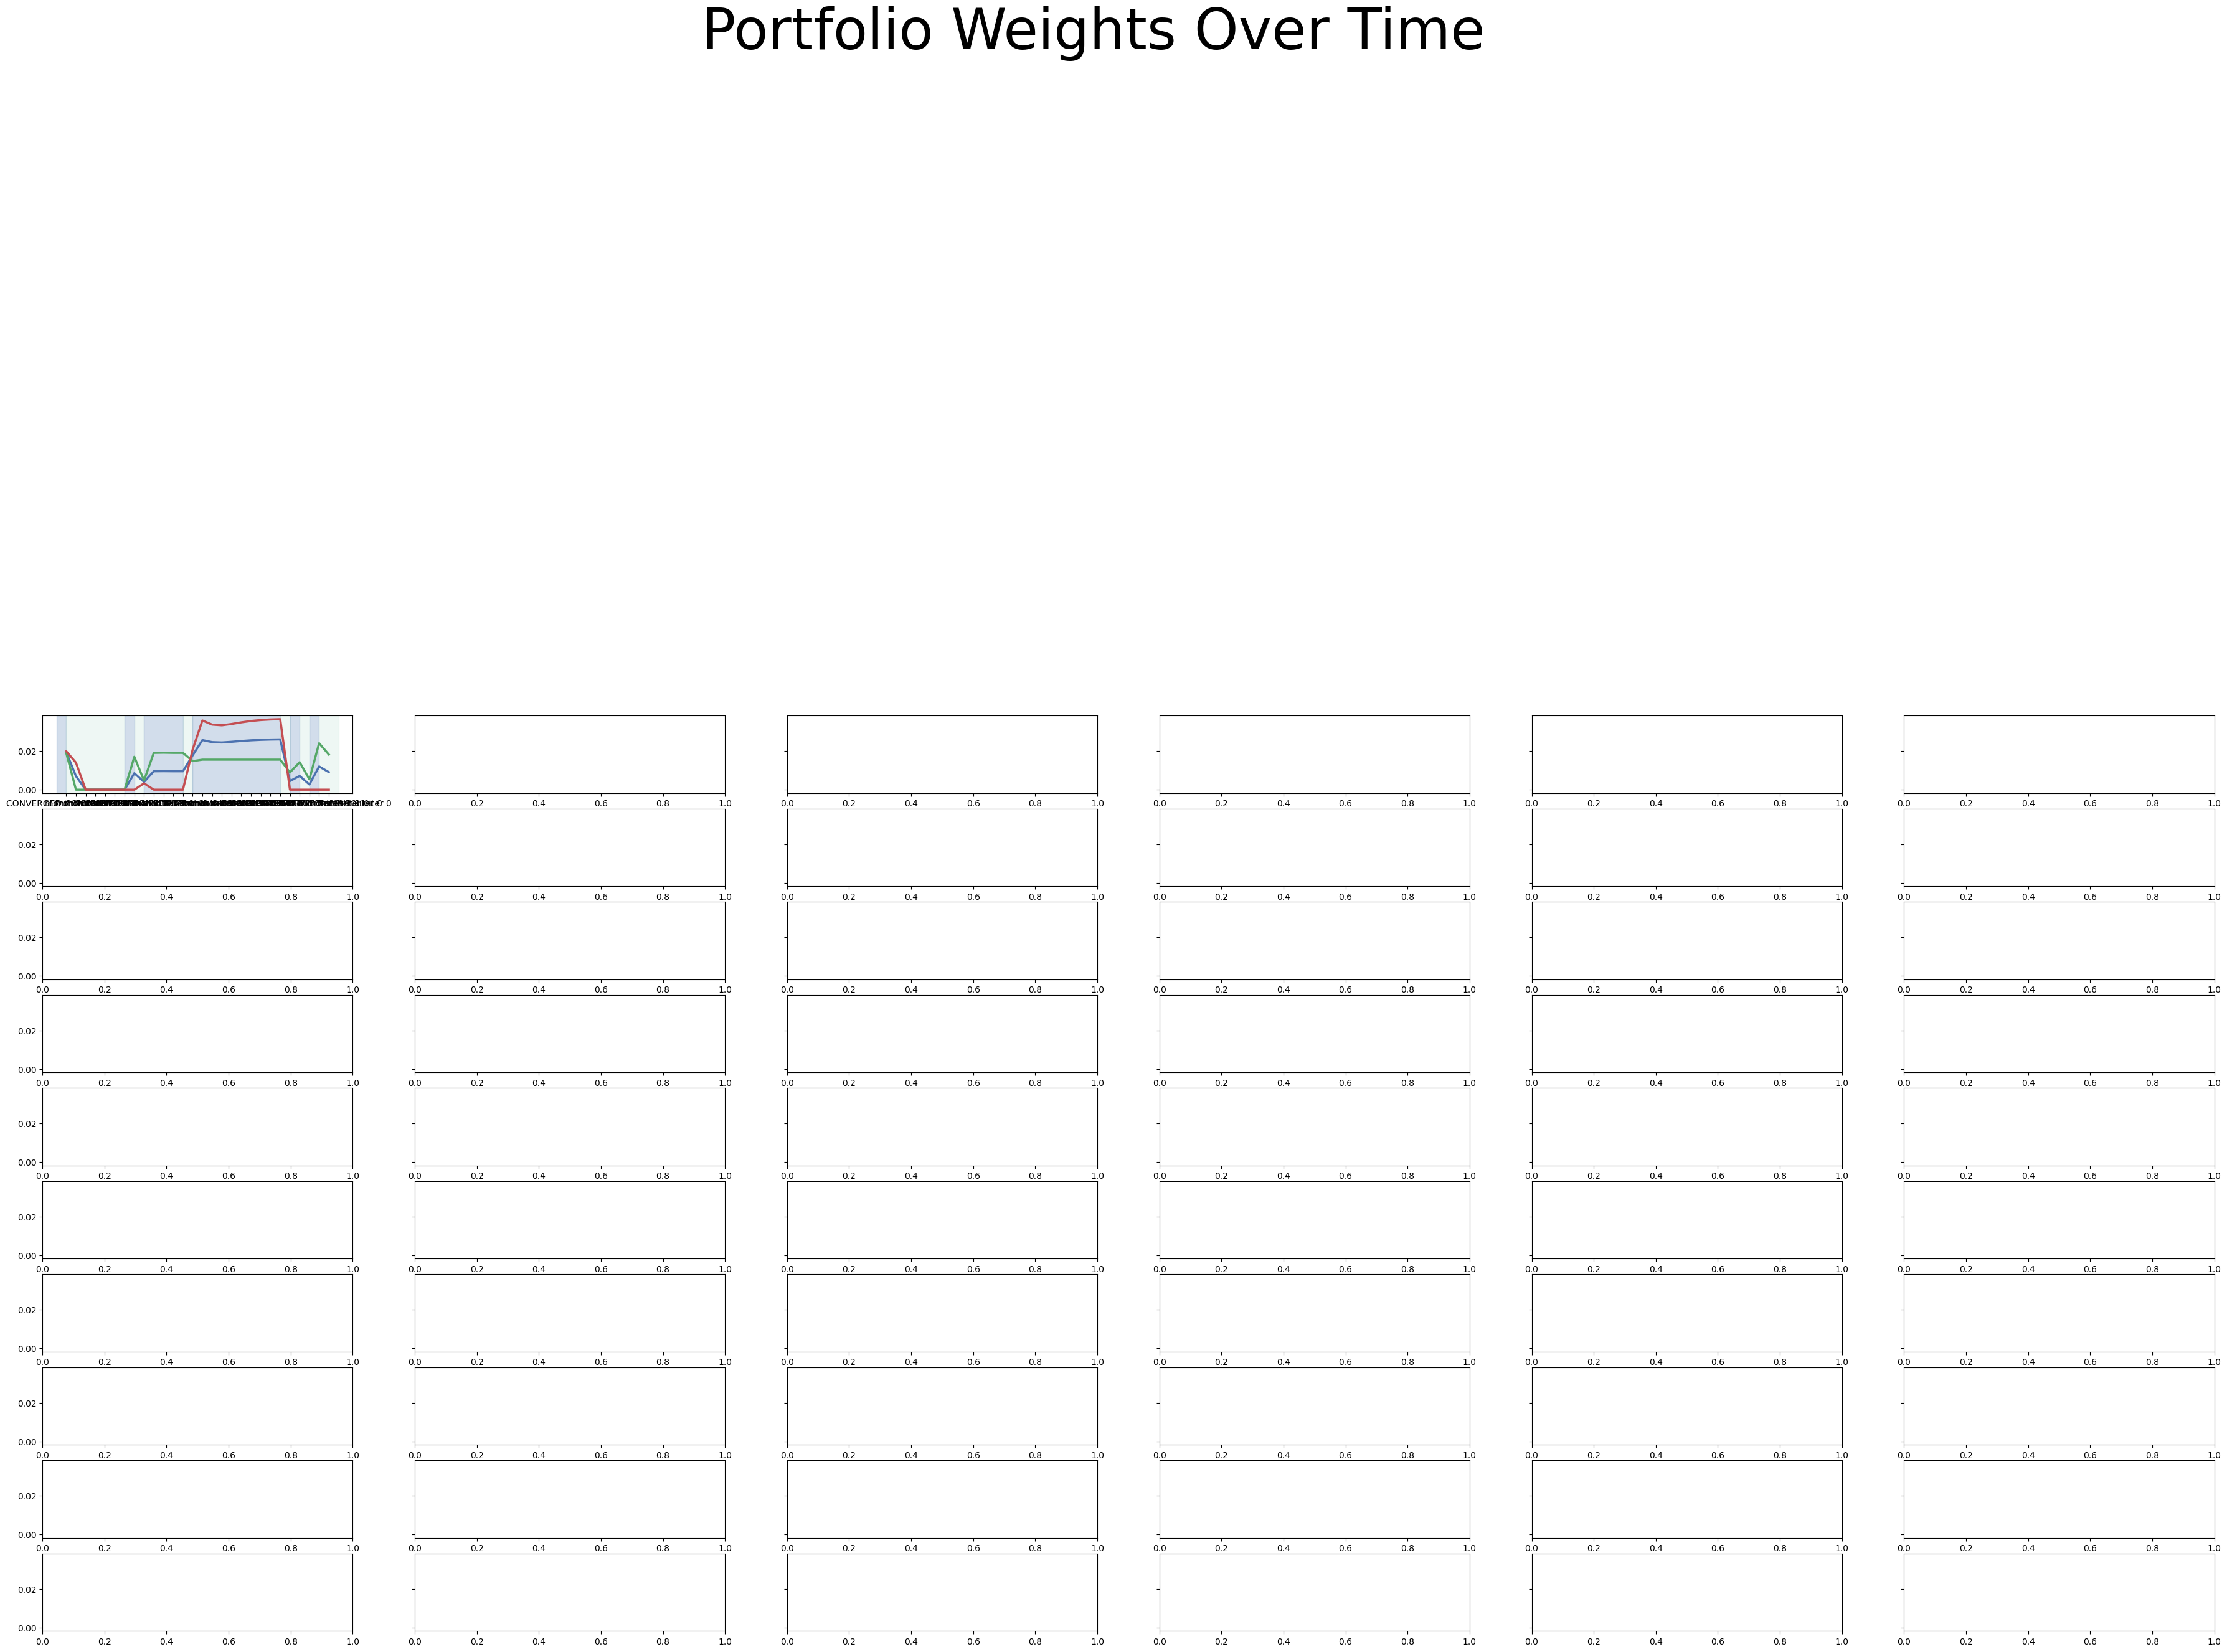

In [36]:
rows = 10
columns = 6

fig, axes = plt.subplots(rows, columns, figsize=(45, 30), sharey=True)
fig.suptitle("Portfolio Weights Over Time\n", fontsize=65)
plt.subplots_adjust(top=0.6)  

# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Define regions and colors
blue_region = (round(108/255, 2), round(143/255, 2), round(191/255, 2), 0.3)
green_region = (round(201/255, 2), round(230/255, 2), round(219/255, 2), 0.3)

days = []
prev = 0

for i, log in enumerate(df['status']):
    log = log.split()
    j = log.index("month")
    cur = log[j+1]
    if cur != prev:
        days.append(i-1)
        prev = cur

days.append(i+1)

regions = []
for i in range(len(days)-1):
    region_color = blue_region if i % 2 == 0 else green_region
    regions.append((days[i], days[i+1], region_color))

# Generate x-tick labels, hiding those without "CONVERGED"
xtick_labels = []
for status in df['status']:
    if "CONVERGED" in status:
        xtick_labels.append(status)
    else:
        xtick_labels.append("")  # Blank label for non-CONVERGED iterations

for i in range(rows * columns):

    isEmpty = False

    try:
        ticker = tickers[i]
    except:
        ticker = None
        isEmpty = True
    
    # Fill regions
    for start, end, color in regions:
        axes[i].axvspan(start, end, color=color, alpha=0.3)

    if ticker:
        # Plot lines
        if i == 0:
            axes[i].plot(df['status'], df[f'all {ticker}'], label='Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], df[f'llm {ticker}'], label='LLM in Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], df[f'opt {ticker}'], label='Opt in Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], pure_llm_history[i], label='Pure LLM', linewidth=2.5, alpha=0.5)
            axes[i].plot(df['status'], pure_opt_history[i], label='Pure Opt', linewidth=2.5, alpha=0.5)
        else:
            axes[i].plot(df['status'], df[f'all {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], df[f'llm {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], df[f'opt {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], pure_llm_history[i], linewidth=2.5, alpha=0.5)
            axes[i].plot(df['status'], pure_opt_history[i], linewidth=2.5, alpha=0.5)
        
        # Title and tick parameters
        axes[i].set_title(f'{ticker}', fontsize=40)

    axes[i].tick_params(axis='x', rotation=90, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

    # Set x-tick labels with filtered labels
    axes[i].set_xticks(range(len(df['status'])))
    axes[i].set_xticklabels(xtick_labels, fontsize=15, ha='right')
    
    # X-axis limit
    axes[i].set_xlim(0, len(df['status']) - 1)

    
    # Y-label on first column
    if i in [i for i in range(0, rows*columns, columns)]:
        cat = '\n'.join(stock_categories[i//columns].split())
        axes[i].set_ylabel(f"{cat}\n\nWeights", fontsize=25)
    
    # X-label only on last row
    if i in [i for i in range(rows*columns-columns, rows*columns)]:
        axes[i].set_xlabel("Iteration", fontsize=25)
    else:
        # Hide x-tick labels for the first two rows
        axes[i].tick_params(axis='x', labelbottom=False)

# Add common legend (adjust location as you like)
# fig.legend(loc=(0.00, 0.95), ncol=2, fontsize=20)
fig.legend(loc=(0.00, 0.965), ncol=5, fontsize=20)

plt.tight_layout()

plt.savefig(grid_image_path, dpi=300) # , bbox_inches='tight'  
plt.show()

#### Graph individual results

In [639]:
if True:
    # create directory
    os.makedirs(directory_path, exist_ok=True)

    for i, ticker in enumerate(tickers):
        fig, ax = plt.subplots(figsize=(12, 8))  # Adjust size as desired

        # Fill background regions
        for start, end, color in regions:
            ax.axvspan(start, end, color=color, alpha=0.3)

        # Plot lines for this ticker
        ax.plot(df['status'], df[f'all {ticker}'], label='Coordinator', linewidth=2.5)
        ax.plot(df['status'], df[f'llm {ticker}'], label='LLM in Coordinator', linewidth=2.5)
        ax.plot(df['status'], df[f'opt {ticker}'], label='Opt in Coordinator', linewidth=2.5)
        # ax.plot(df['status'], pure_llm_history[i], label='Pure LLM', linewidth=2.5, alpha=0.5)
        # ax.plot(df['status'], pure_opt_history[i], label='Pure Opt', linewidth=2.5, alpha=0.5)

        # Title and style
        ax.set_title(f"{ticker}", fontsize=18)
        ax.tick_params(axis='x', rotation=90, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

        # X-tick labels (with blanks for non-CONVERGED, as in your original logic)
        ax.set_xticks(range(len(df['status'])))
        ax.set_xticklabels(xtick_labels, fontsize=10, ha='right')

        # Set x-limits
        ax.set_xlim(0, len(df['status']) - 1)

        # Optionally add a legend on each chart (or remove if you prefer no legend)
        ax.legend(fontsize=10, loc='upper left')

        # Save to file; use ticker name in the filename
        plt.tight_layout()
        plt.savefig(f"assets/indiv/{appendage}_{iteration}/chart_{ticker}.png", dpi=450)  # or any naming scheme you like
        plt.close(fig)  # Close the figure to free memory

#### Sparse

In [ ]:
df_filtered_sparse = df_sparse[df_sparse['status'].str.contains("CONVERGED")]
df_filtered_sparse.set_index('status', inplace=True)

In [ ]:
rows = 10
columns = 6

fig, axes = plt.subplots(rows, columns, figsize=(45, 30), sharey=True)
fig.suptitle("(Sparse) Portfolio Weights Over Time\n", fontsize=65)
plt.subplots_adjust(top=0.6)  

# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Define regions and colors
days = []
prev = 0

for i, log in enumerate(df_sparse['status']):
    log = log.split()
    j = log.index("month")
    cur = log[j+1]
    if cur != prev:
        days.append(i-1)
        prev = cur

days.append(i+1)

regions = []
for i in range(len(days)-1):
    region_color = blue_region if i % 2 == 0 else green_region
    regions.append((days[i], days[i+1], region_color))

# Generate x-tick labels, hiding those without "CONVERGED"
xtick_labels = []
for status in df_sparse['status']:
    if "CONVERGED" in status:
        xtick_labels.append(status)
    else:
        xtick_labels.append("")  # Blank label for non-CONVERGED iterations

for i in range(rows * columns):

    try:
        ticker = tickers[i]
    except:
        ticker = None
    
    # Fill regions
    for start, end, color in regions:
        axes[i].axvspan(start, end, color=color, alpha=0.3)

    if ticker:
        # Plot lines
        if i == 0:
            axes[i].plot(df_sparse['status'], df_sparse[f'all {ticker}'], label='Coordinator', linewidth=2.5)
            axes[i].plot(df_sparse['status'], df_sparse[f'llm {ticker}'], label='LLM in Coordinator', linewidth=2.5)
            axes[i].plot(df_sparse['status'], df_sparse[f'opt {ticker}'], label='Opt in Coordinator', linewidth=2.5)
        else:
            axes[i].plot(df_sparse['status'], df_sparse[f'all {ticker}'], linewidth=2.5)
            axes[i].plot(df_sparse['status'], df_sparse[f'llm {ticker}'], linewidth=2.5)
            axes[i].plot(df_sparse['status'], df_sparse[f'opt {ticker}'], linewidth=2.5)
        
        # Title and tick parameters
        axes[i].set_title(f'{ticker}', fontsize=40)

    axes[i].tick_params(axis='x', rotation=90, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

    # Set x-tick labels with filtered labels
    axes[i].set_xticks(range(len(df_sparse['status'])))
    axes[i].set_xticklabels(xtick_labels, fontsize=15, ha='right')
    
    # X-axis limit
    axes[i].set_xlim(0, len(df_sparse['status']) - 1)

    
    # Y-label on first column
    if i in [i for i in range(0, rows*columns, columns)]:
        cat = '\n'.join(stock_categories[i//columns].split())
        axes[i].set_ylabel(f"{cat}\n\nWeights", fontsize=25)
    
    # X-label only on last row
    if i in [i for i in range(rows*columns-columns, rows*columns)]:
        axes[i].set_xlabel("Iteration", fontsize=25)
    else:
        # Hide x-tick labels for the first two rows
        axes[i].tick_params(axis='x', labelbottom=False)

# Add common legend (adjust location as you like)
# fig.legend(loc=(0.00, 0.95), ncol=2, fontsize=20)
fig.legend(loc=(0.00, 0.965), ncol=5, fontsize=20)

plt.tight_layout()

plt.savefig(grid_image_path, dpi=300) # , bbox_inches='tight'  
plt.show()

In [ ]:
if True:
    # create directory
    os.makedirs(directory_path_sparse, exist_ok=True)

    for i, ticker in enumerate(tickers):
        fig, ax = plt.subplots(figsize=(12, 8))  # Adjust size as desired

        # Fill background regions
        for start, end, color in regions:
            ax.axvspan(start, end, color=color, alpha=0.3)

        # Plot lines for this ticker
        ax.plot(df_sparse['status'], df_sparse[f'all {ticker}'], label='Coordinator', linewidth=2.5)
        ax.plot(df_sparse['status'], df_sparse[f'llm {ticker}'], label='LLM in Coordinator', linewidth=2.5)
        ax.plot(df_sparse['status'], df_sparse[f'opt {ticker}'], label='Opt in Coordinator', linewidth=2.5)
        # ax.plot(df_sparse['status'], pure_llm_history[i], label='Pure LLM', linewidth=2.5, alpha=0.5)
        # ax.plot(df_sparse['status'], pure_opt_history[i], label='Pure Opt', linewidth=2.5, alpha=0.5)

        # Title and style
        ax.set_title(f"{ticker}", fontsize=18)
        ax.tick_params(axis='x', rotation=90, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

        # X-tick labels (with blanks for non-CONVERGED, as in your original logic)
        ax.set_xticks(range(len(df_sparse['status'])))
        ax.set_xticklabels(xtick_labels, fontsize=10, ha='right')

        # Set x-limits
        ax.set_xlim(0, len(df_sparse['status']) - 1)

        # Optionally add a legend on each chart (or remove if you prefer no legend)
        ax.legend(fontsize=10, loc='upper left')

        # Save to file; use ticker name in the filename
        plt.tight_layout()
        plt.savefig(f"assets/indiv/{appendage}_{iteration}/chart_{ticker}.png", dpi=450)  # or any naming scheme you like
        plt.close(fig)  # Close the figure to free memory

#### Backtesting
Seeing how the strategies perform based on historical data

In [185]:
# get the beginning price for each month
df_init = df[df['status'].str.contains('iter 0')].reset_index(drop=True)
df_end = df.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)

df_init_sparse = df_sparse[df_sparse['status'].str.contains('iter 0')].reset_index(drop=True)
df_end_sparse = df_sparse.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)

all_weights = ["all " + ticker for ticker in tickers]

In [236]:
def backtest(df, columns=None, weights_=None):
    i = 0
    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]
    # Create a DataFrame to track monthly PnL for each ticker
    monthly_pnl = pd.DataFrame(0.0, index=range(12), columns=tickers)

    while i < 11:
        # ---- 1) Get the weights for this month (end of month i) ----
        if columns:
            weights = df.loc[i, columns].tolist()
        else:
            weights = weights_[i]

        # ---- 2) Buy using these weights ----
        shares = []
        buy_prices = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            buy_price = data_loaded[i][ticker]['price']
            buy_prices.append(buy_price)

            allocation = initial_capital * weights[j]  # portion of capital
            shares_bought = allocation / buy_price if buy_price > 0 else 0
            shares.append(shares_bought)

            # Deduct spent cash
            portfolio_value -= shares_bought * buy_price

        # ---- 3) Sell at month i+1 (end of next month), record PnL per ticker ----
        i += 1
        for j, ticker in enumerate(tickers):
            sell_price = data_loaded[i][ticker]['price']
            # PnL for this ticker in month i-1 (e.g. row 0 if i=1 now)
            pnl = shares[j] * (sell_price - buy_prices[j])
            monthly_pnl.loc[i - 1, ticker] = pnl  # store PnL

            # Update portfolio value by the proceeds of selling
            portfolio_value += shares[j] * sell_price

        portfolio_history.append(portfolio_value)

    print("Final Portfolio Value:", portfolio_value)
    # Return both the total portfolio value history and the per-ticker monthly PnL
    return portfolio_history, monthly_pnl

# For example, the coordinated strategy:
portfolio_history_coordinated, pnl_coordinated = backtest(df_end, columns=all_weights)
portfolio_history_coordinated_sparse, pnl_coordinated_sparse = backtest(df_end_sparse, columns=all_weights)

# Or the pure OPT strategy:
portfolio_history_opt, pnl_opt = backtest(df_init, weights_=opt_histories)

# Or the pure LLM strategy:
portfolio_history_llm, pnl_llm = backtest(df_init, weights_=llm_histories)
portfolio_history_llm_sparse, pnl_llm_sparse = backtest(df_init_sparse, weights_=llm_histories_sparse)

Final Portfolio Value: 14414.208660595143
Final Portfolio Value: 8769.177287062801
Final Portfolio Value: 8769.289389327138
Final Portfolio Value: 9421.11954880515
Final Portfolio Value: 13713.580838224396


#### Plot the backtesting

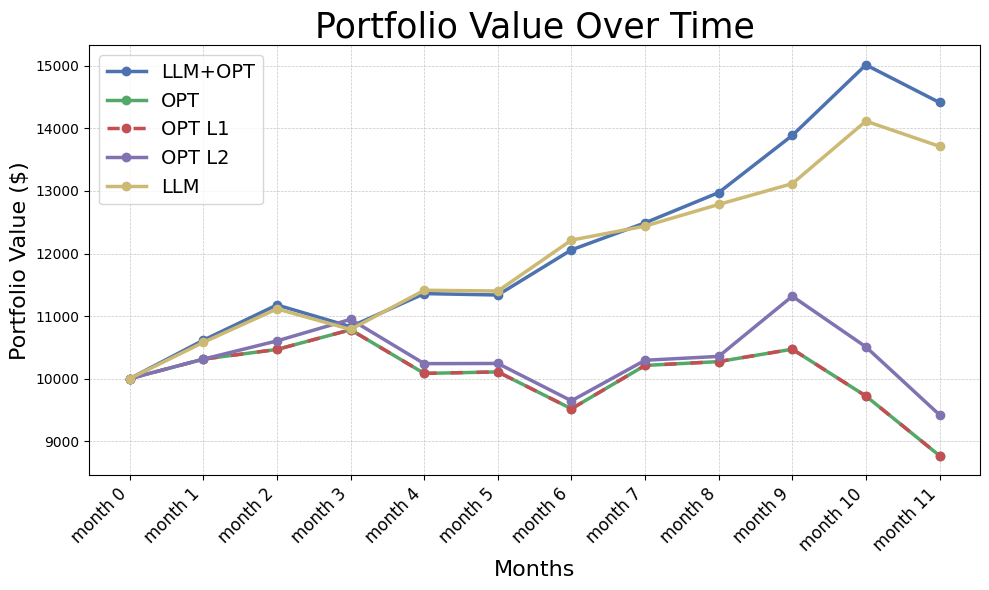

In [245]:
# Create labels for months 0 through 11
months = [f"month {i}" for i in range(12)]

plt.figure(figsize=(10, 6))

# Plot as a line chart with markers
plt.plot(months, portfolio_history_coordinated, linestyle='-', marker='o', linewidth=2.5, label='LLM+OPT')
plt.plot(months, portfolio_history_coordinated_sparse, linestyle='-', marker='o', linewidth=2.5, label='LLM_sparse+OPT')
plt.plot(months, portfolio_history_opt, linestyle='-', marker='o', linewidth=2.5, label='OPT')
plt.plot(months, portfolio_history_llm, linestyle='-', marker='o', linewidth=2.5, label='LLM')
plt.plot(months, portfolio_history_llm_sparse, linestyle='-', marker='o', linewidth=2.5, label='LLM_sparse')

# Add a title, axis labels, and grid
plt.title("Portfolio Value Over Time", fontsize=25)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Portfolio Value ($)", fontsize=16)

# Improve grid styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend with larger font size
plt.legend(fontsize=14, loc='upper left')

# Rotate x-tick labels and align them to the right
plt.xticks(fontsize=12, rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.savefig(pft_value_over_time_path, dpi=500, bbox_inches='tight')  
plt.show()

#### Heat Map

In [ ]:
# only get the coordination results
df_filtered_all = df_filtered.loc[:, df_filtered.columns.str.contains(r'\ball\b', case=False)]
df_filtered_all.columns = df_filtered_all.columns.str.replace(r'^all ', '', regex=True)

# get average
mean_values = df_filtered_all.mean()
df_filtered_ticker_name = pd.DataFrame([mean_values])
df_filtered_ticker_name.reset_index(drop=True, inplace=True)

df_filtered_ticker_name

,NVDA,AMD,MSFT,AAPL,INTC,PLTR,TSLA,AMZN,SBUX,TGT,NFLX,MCD,HOOD,BAC,JPM,MS,V,SCHW,ZG,PLD,WELL,SPG,PSA,EQR,GEV,XOM,DUK,NEE,EOG,SLB,TEM,UNH,PFE,MRNA,ABBV,MDT,CAT,BA,LMT,DE,GD,HON,PCT,NEM,LIN,APD,FCX,MLM,GOOG,TMUS,META,DIS,VZ,CMCSA,COST,PEP,WMT,KO,PG,MO
0,0.010059,0.016086,0.010332,0.016457,0.003498,0.023298,0.019284,0.008555,0.017227,0.018174,0.020852,0.019534,0.020476,0.004709,0.012719,0.024965,0.013659,0.016773,0.014808,0.0174,0.014301,0.012342,0.010889,0.005296,0.020858,0.020853,0.020691,0.017788,0.014674,0.00401,0.019258,0.024151,0.021319,0.007947,0.020445,0.045747,0.015123,0.011196,0.0101,0.022626,0.022253,0.018147,0.016395,0.018641,0.014633,0.023001,0.021236,0.016303,0.017508,0.01245,0.020607,0.018359,0.014677,0.011988,0.019537,0.017644,0.016525,0.019836,0.016171,0.015611


In [ ]:
# only get the coordination results
df_filtered_all_sparse = df_filtered_sparse.loc[:, df_filtered_sparse.columns.str.contains(r'\ball\b', case=False)]
df_filtered_all_sparse.columns = df_filtered_all_sparse.columns.str.replace(r'^all ', '', regex=True)

# get average
mean_values_sparse = df_filtered_all_sparse.mean()
df_filtered_ticker_name_sparse = pd.DataFrame([mean_values_sparse])
df_filtered_ticker_name_sparse.reset_index(drop=True, inplace=True)

df_filtered_ticker_name_sparse

In [ ]:
llm_histories_np_array = np.array(llm_histories)
df_llm_histories = pd.DataFrame(llm_histories_np_array, columns=tickers)
mean_llm_values = df_llm_histories.mean()
df_llm_histories_mean = pd.DataFrame([mean_llm_values])
df_llm_histories_mean.reset_index(drop=True, inplace=True)

df_llm_histories_mean

,NVDA,AMD,MSFT,AAPL,INTC,PLTR,TSLA,AMZN,SBUX,TGT,NFLX,MCD,HOOD,BAC,JPM,MS,V,SCHW,ZG,PLD,WELL,SPG,PSA,EQR,GEV,XOM,DUK,NEE,EOG,SLB,TEM,UNH,PFE,MRNA,ABBV,MDT,CAT,BA,LMT,DE,GD,HON,PCT,NEM,LIN,APD,FCX,MLM,GOOG,TMUS,META,DIS,VZ,CMCSA,COST,PEP,WMT,KO,PG,MO
0,0.010568,0.020044,0.011313,0.019178,0.003082,0.021252,0.020044,0.013636,0.016046,0.020829,0.02047,0.016458,0.01645,0.007418,0.016483,0.019265,0.014392,0.017726,0.016806,0.020784,0.018035,0.016411,0.015311,0.010045,0.018769,0.018443,0.018455,0.01688,0.019686,0.005934,0.017654,0.016309,0.01962,0.011947,0.018494,0.01603,0.021434,0.014577,0.0106,0.017614,0.019696,0.017825,0.020051,0.018455,0.020058,0.017708,0.020442,0.019319,0.01684,0.012587,0.017605,0.017638,0.018106,0.014779,0.019106,0.018845,0.014519,0.019943,0.014665,0.017322


In [ ]:
llm_histories_np_array_sparse = np.array(llm_histories_sparse)
df_llm_histories_sparse = pd.DataFrame(llm_histories_np_array_sparse, columns=tickers)
mean_llm_values_sparse = df_llm_histories_sparse.mean()
df_llm_histories_mean_sparse = pd.DataFrame([mean_llm_values_sparse])
df_llm_histories_mean_sparse.reset_index(drop=True, inplace=True)

df_llm_histories_mean_sparse

In [248]:
opt_histories_np_array = np.array(opt_histories)
df_opt_histories = pd.DataFrame(opt_histories_np_array, columns=tickers)
mean_opt_values = df_opt_histories.mean()
df_opt_histories_mean = pd.DataFrame([mean_opt_values])
df_opt_histories_mean.reset_index(drop=True, inplace=True)

df_opt_histories_mean

,NVDA,AMD,MSFT,AAPL,INTC,PLTR,TSLA,AMZN,SBUX,TGT,NFLX,MCD,HOOD,BAC,JPM,MS,V,SCHW,ZG,PLD,WELL,SPG,PSA,EQR,GEV,XOM,DUK,NEE,EOG,SLB,TEM,UNH,PFE,MRNA,ABBV,MDT,CAT,BA,LMT,DE,GD,HON,PCT,NEM,LIN,APD,FCX,MLM,GOOG,TMUS,META,DIS,VZ,CMCSA,COST,PEP,WMT,KO,PG,MO
0,1.559774e-11,1.503530e-11,1.094505e-11,1.469687e-11,0.003138,1.254774e-11,1.337909e-11,1.284141e-11,1.430355e-11,1.550954e-11,1.351423e-11,1.210628e-11,1.805339e-11,2.231971e-11,1.730658e-11,0.08333,1.757739e-11,0.006858,0.004921,1.786148e-11,0.16449,9.784999e-12,1.279455e-11,1.899726e-11,1.314219e-11,2.954321e-10,1.435861e-11,1.290527e-11,1.419414e-11,1.274208e-11,1.938080e-11,0.083332,1.431166e-11,1.257184e-11,2.824876e-11,0.089491,3.871339e-09,0.086672,0.261446,1.798717e-11,1.455471e-11,1.319537e-10,1.149911e-11,0.117123,0.029426,3.127471e-08,1.878033e-11,1.448076e-11,1.180135e-11,0.050769,1.187585e-11,1.723111e-11,2.456118e-10,1.349900e-11,1.407367e-11,0.005881,2.008582e-11,1.686014e-11,1.822359e-11,0.013122


In [267]:
df_mean_total = pd.concat([
    df_filtered_ticker_name, 
    df_filtered_ticker_name_sparse,
    df_llm_histories_mean, 
    df_llm_histories_mean_sparse, 
    df_opt_histories_mean], axis=0, ignore_index=True)

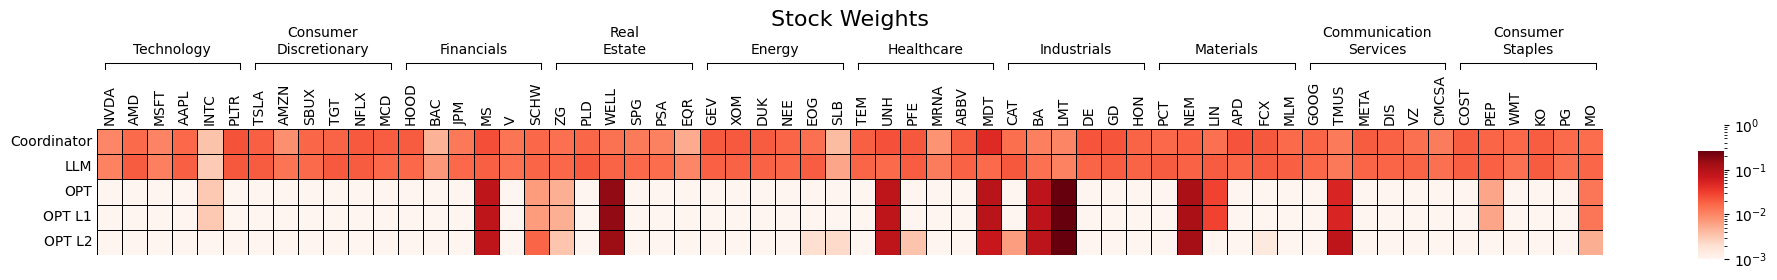

In [284]:
import seaborn as sns

vmin = 1e-3  # Set a minimum value for log scaling to avoid issues with log(0)
vmax = max([n for n in df_mean_total.values.flatten().tolist() if isinstance(n, float)])  # Maximum value in the data

plt.figure(figsize=(20, 2.5))  # Adjust the figure size for better visualization
ax = sns.heatmap(
    df_mean_total, 
    cmap="Reds", 
    linewidths=0.5, 
    linecolor="black", 
    annot=False, 
    cbar=True, 
    cbar_kws={"aspect": 5},
    square=True,
    xticklabels=True,
    yticklabels=["LLM+OPT", "LLM_sparse+OPT", "LLM", "LLM_sparse", "OPT"],
    vmin=0, 
    vmax=max([n for n in df_mean_total.values.flatten().tolist() if isinstance(n, float)]),  # Scale from 0 to max value in the data
    norm=mcolors.LogNorm(vmin=vmin, vmax=vmax)
)

cbar = ax.collections[0].colorbar
cbar.set_ticks([1e-3, 1e-2, 1e-1, 1e0])  # Include 10^0
cbar.set_ticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$"])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.tick_params(axis="both", length=0)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tick_params(axis="x", top=True, labeltop=True, labelbottom=False)
plt.xlabel(None)
plt.ylabel(None)

categories = [
    'Technology',
    'Consumer Discretionary',
    'Financials',
    'Real Estate',
    'Energy',
    'Healthcare',
    'Industrials',
    'Materials',
    'Communication Services',
    'Consumer Staples'
]

# Vertical/horizontal offsets for the bracket
y_bottom = 1.48
y_top = y_bottom + 0.05
margin = 0.3  # how much to pull in from each side so brackets don't overlap
linewidth = 0.75

for i, cat in enumerate(categories):
    x_left = i * 6 + margin
    x_right = (i + 1) * 6 - margin

    # Left vertical line
    ax.plot([x_left, x_left], [y_bottom, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Right vertical line
    ax.plot([x_right, x_right], [y_bottom, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Horizontal top line
    ax.plot([x_left, x_right], [y_top, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Category label
    ax.text((x_left + x_right) / 2, y_top + 0.05, '\n'.join(cat.split())+'',
            ha="center", va="bottom", transform=ax.get_xaxis_transform(), fontsize=10)

plt.title("Stock Weights", fontsize=16, pad=35)
plt.tight_layout()

plt.savefig(heatmap_path, dpi=500, bbox_inches='tight')  
plt.show()

#### Stock Weights per Month

In [305]:
df_total = pd.concat([
    df_filtered_all,
    df_filtered_all_sparse, 
    df_llm_histories, 
    df_llm_histories_sparse,
    df_opt_histories])

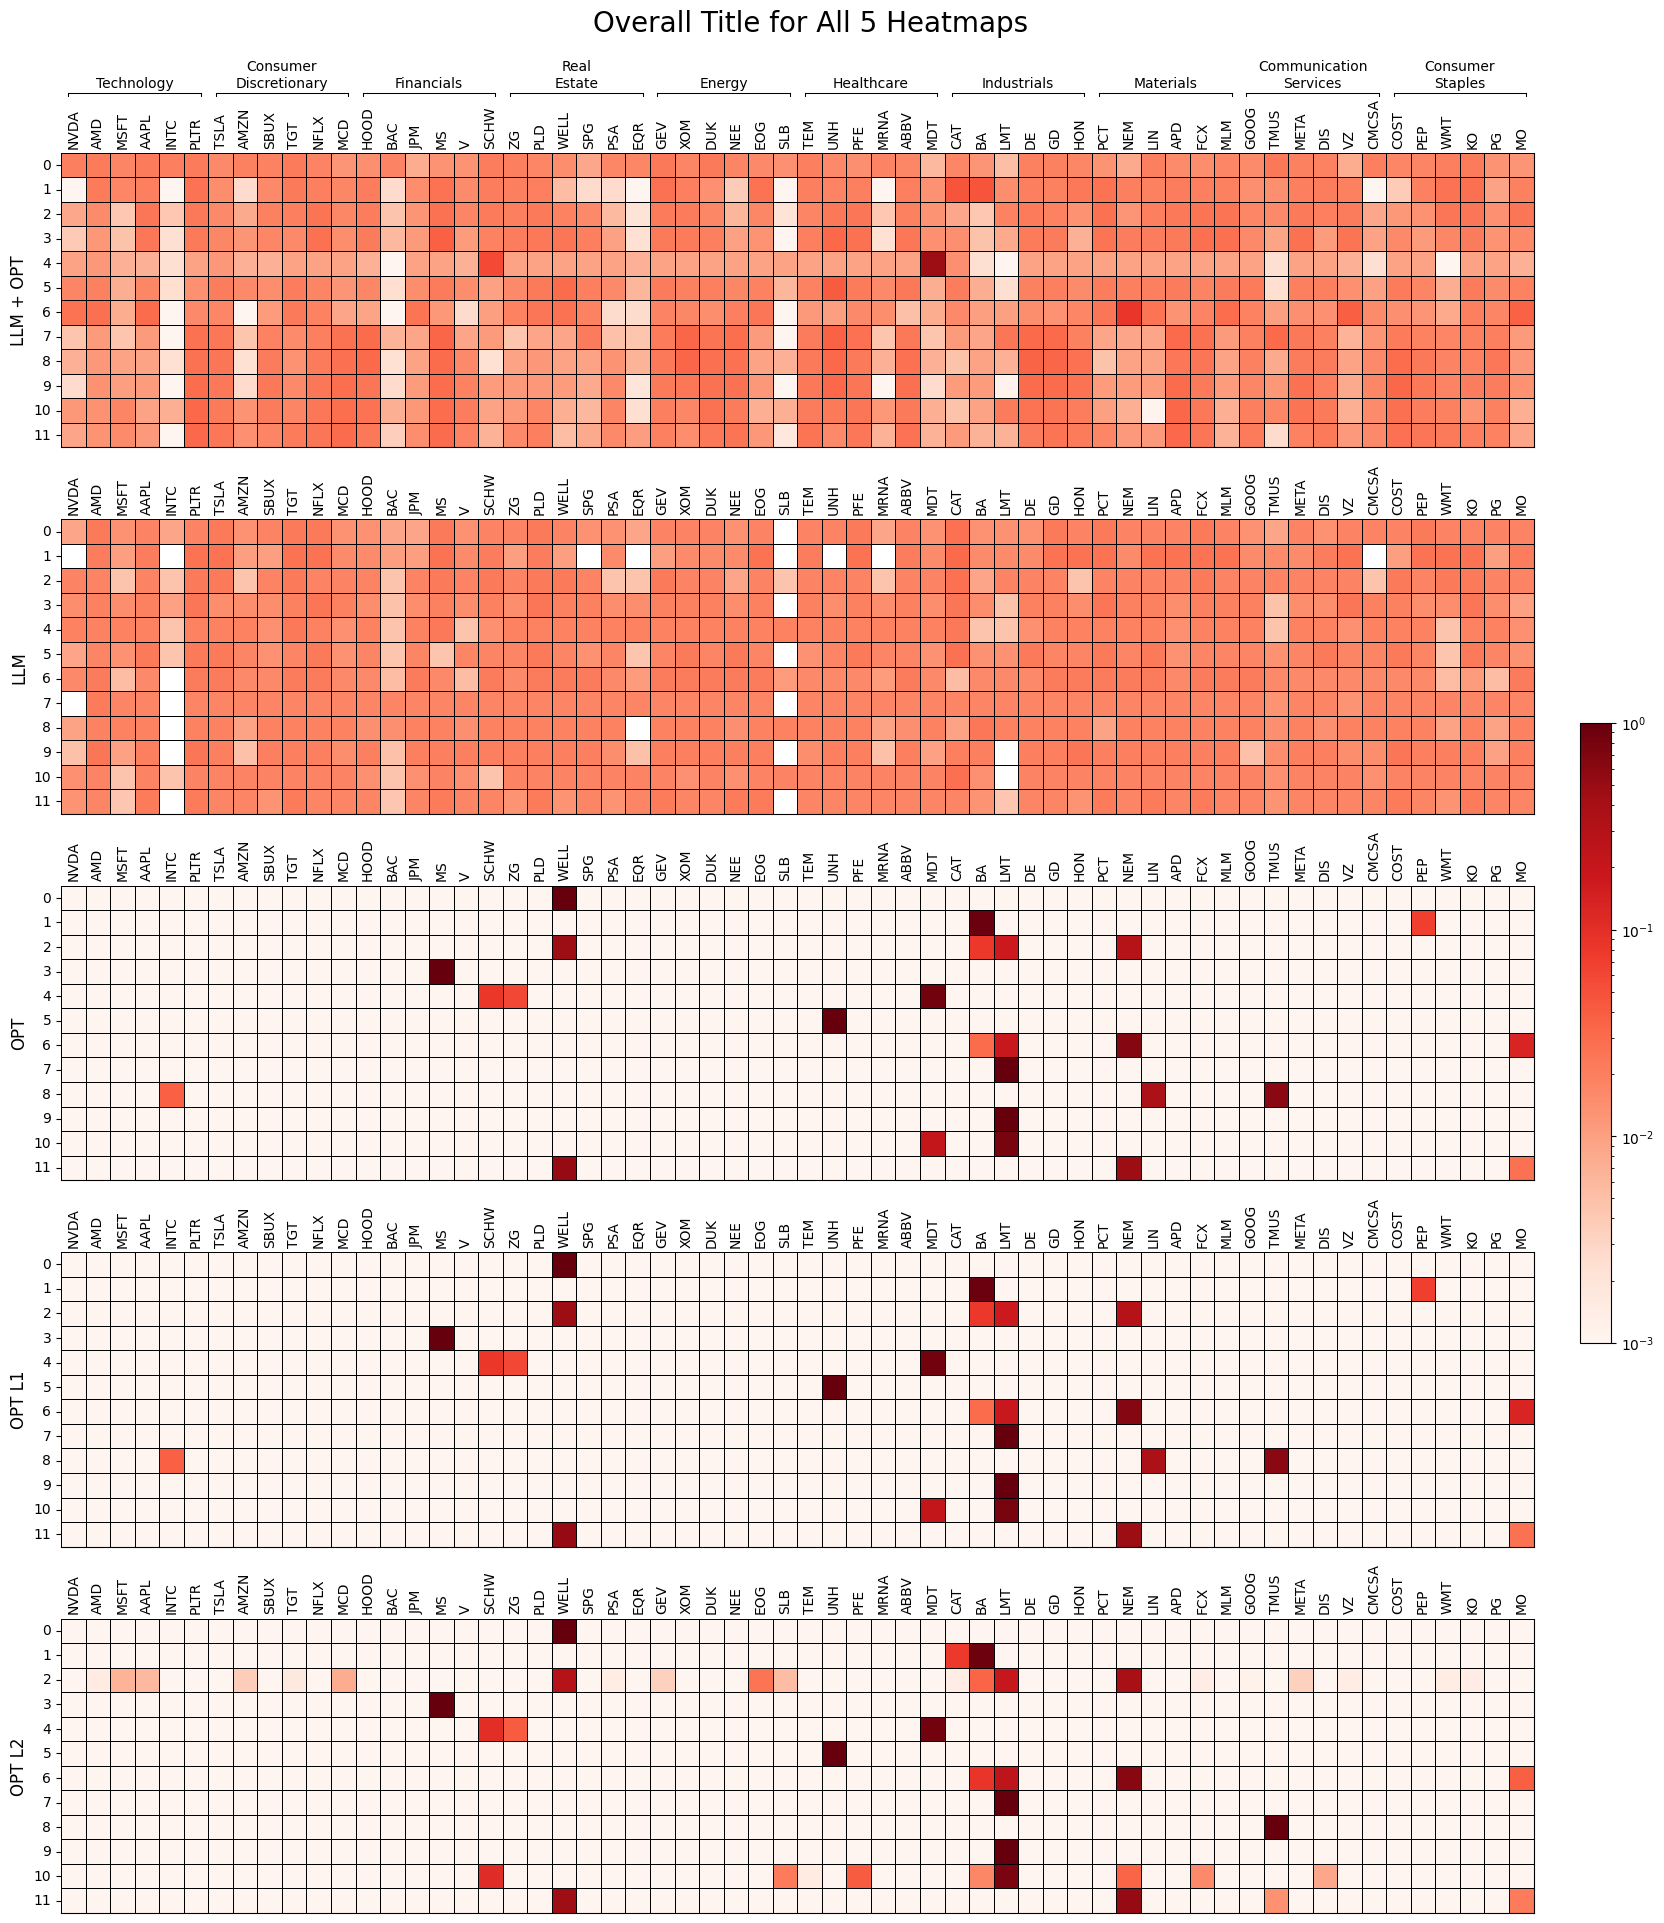

In [321]:
# Example data: Suppose df_total has 60 rows (5 sets of 12).
# Adapt to match your real data shape.
n_rows = 60
n_cols = 10

# -- FIGURE AND AXES --
fig, axes = plt.subplots(nrows=5, figsize=(20, 23), sharex=True)

# -- SETUP LOG NORM --
vmin = 1e-3
vmax = df_total.values.max()
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# We'll create a single colorbar at the end, so set cbar=False for each subplot
# The data range is the same for all subplots, so we can just pick the last heatmap's
# "mappable" to feed into fig.colorbar() later.
mappable = None

labels = ["LLM+OPT", "LLM_sparse+OPT", "LLM", "LLM_sparse", "OPT"]

for i in range(5):
    ax = axes[i]
    
    sub_df = df_total.iloc[i*12 : (i+1)*12, :]

    # Create the heatmap with no colorbar
    hmap = sns.heatmap(
        sub_df,
        cmap="Reds",
        linewidths=0.5,
        linecolor="black",
        annot=False,
        square=True,
        cbar=False,      # No inline colorbar
        vmin=vmin,
        vmax=vmax,
        norm=norm,
        ax=ax
    )
    
    # Save the "mappable" from the last heatmap in the loop.
    # We can use any subplot's "mappable" for the colorbar, 
    # but just store one (e.g. from the last iteration).
    mappable = hmap.collections[0]

    # Turn off bottom tickers; optionally place them on top.
    ax.tick_params(axis='x', 
                   bottom=False, labelbottom=False,   # Turn off bottom
                   top=True, labeltop=True,           # Put ticks on top
                   length=0)

    # y-axis labels (just an example: row numbers 0..11)
    ytick_positions = np.arange(sub_df.shape[0]) + 0.5
    ax.set_yticks(ytick_positions)
    ax.set_yticklabels([str(y) for y in range(sub_df.shape[0])], rotation=0)

    # Label each subplot on the y-axis with your desired text
    ax.set_ylabel(labels[i], fontsize=12)

    # Show only bottom & right spines; hide top & left
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["right"].set_visible(True)

    # Rotate x-tick labels on top
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# -- A SINGLE COLORBAR ON THE RIGHT, SPANNING ALL SUBPLOTS --
# 'mappable' comes from the last heatmap above.
cbar = fig.colorbar(
    mappable, 
    ax=axes.ravel().tolist(),   # attach to all subplots
    orientation='vertical', 
    fraction=0.02, 
    pad=0.03
)
# Adjust the ticks & labels on the colorbar
cbar.set_ticks([1e-3, 1e-2, 1e-1, 1e0])
cbar.set_ticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$"])

categories = [
    'Technology',
    'Consumer Discretionary',
    'Financials',
    'Real Estate',
    'Energy',
    'Healthcare',
    'Industrials',
    'Materials',
    'Communication Services',
    'Consumer Staples'
]

# Vertical/horizontal offsets for the bracket
y_top = 6.18
y_bottom = y_top-0.01
margin = 0.3  # how much to pull in from each side so brackets don't overlap
linewidth = 0.75

for i, cat in enumerate(categories):
    x_left = i * 6 + margin
    x_right = (i + 1) * 6 - margin

    # Left vertical line
    ax.plot([x_left, x_left], [y_bottom, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Right vertical line
    ax.plot([x_right, x_right], [y_bottom, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Horizontal top line
    ax.plot([x_left, x_right], [y_top, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Category label
    ax.text((x_left + x_right) / 2, y_top + 0.01, '\n'.join(cat.split())+'',
            ha="center", va="bottom", transform=ax.get_xaxis_transform(), fontsize=10)

# -- ADD AN OVERALL TITLE --
fig.suptitle("Weights per Stock", fontsize=20, y=0.94)

plt.savefig(heatmap_all_path, dpi=500, bbox_inches='tight')  
plt.tight_layout(rect=[0, 0, 1, 0.95])  

plt.show()

#### Profit and loss from each stock

In [291]:
df_pnl_total = pd.concat([
    pnl_coordinated, 
    pnl_coordinated_sparse, 
    pnl_llm, 
    pnl_llm_sparse, 
    pnl_opt], axis=0, ignore_index=True)

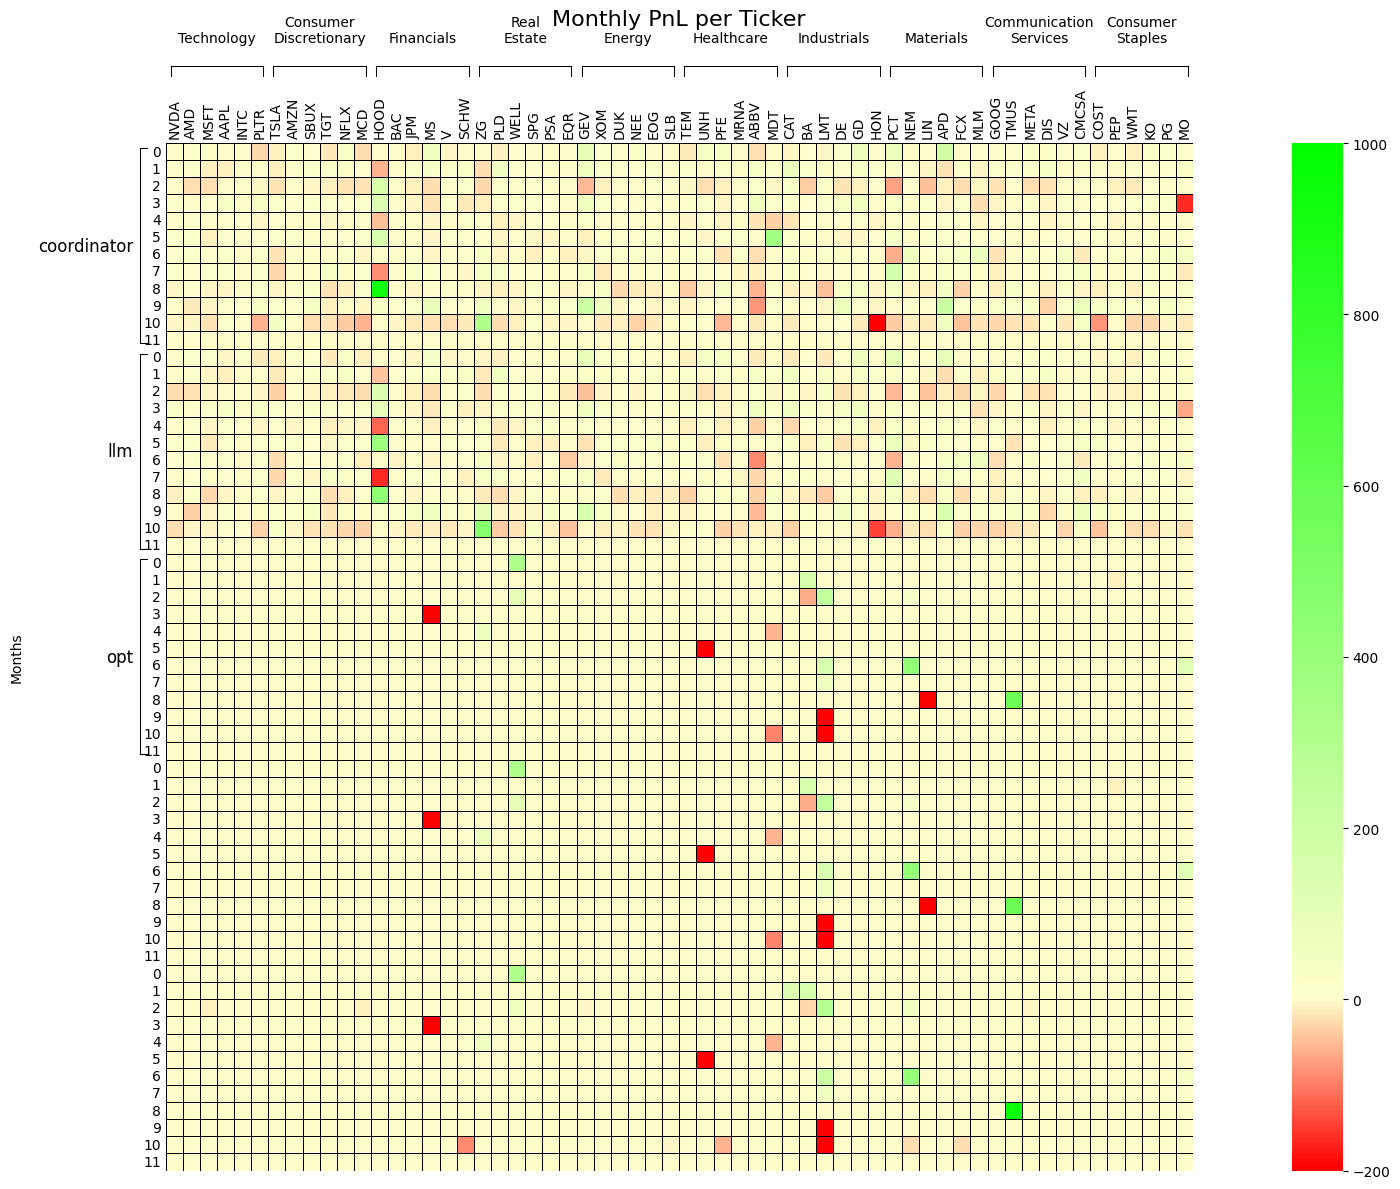

In [ ]:
plt.figure(figsize=(20, 12))

min_val = df_pnl_total.values.min()
max_val = df_pnl_total.values.max()

# 1) Get the built-in RdYlGn colormap
base_cmap = plt.get_cmap("RdYlGn", 256)  # 256 discrete colors

# 2) Convert it to a list so we can modify the middle band
colors = [base_cmap(i) for i in range(base_cmap.N)]

# 3) Make the midpoint less yellow. For example:
#    - The midpoint in a 256-color map is index ~128
#    - Replace it with something lighter (blend with white).
mid_index = 128
original_mid = colors[mid_index]  # RGBA of the original midpoint (~ bright yellow)
# Let's blend that original color with white at, say, 70% original / 30% white:
blend_ratio = 0.7
new_mid = (
    original_mid[0] * blend_ratio + 1.0 * (1 - blend_ratio),
    original_mid[1] * blend_ratio + 1.0 * (1 - blend_ratio),
    original_mid[2] * blend_ratio + 1.0 * (1 - blend_ratio),
    1.0  # keep alpha=1
)
colors[mid_index] = new_mid

# You can also adjust a small band around the midpoint if you want a wider, paler zone
# For example, re-blend indices [120..135] to smoothen the transition:
for idx in range(120, 136):
    c = colors[idx]
    colors[idx] = (
        c[0] * blend_ratio + 1.0 * (1 - blend_ratio),
        c[1] * blend_ratio + 1.0 * (1 - blend_ratio),
        c[2] * blend_ratio + 1.0 * (1 - blend_ratio),
        1.0
    )

# 4) Create a new colormap from our modified colors
my_cmap = mcolors.LinearSegmentedColormap.from_list(
    'ManualCmap',
    [
        (0.0,    (1, 0, 0)),     # red
        (0.1667, (1, 1, 0.8)),   # light yellow
        (1.0,    (0, 1, 0)),     # green
    ],
    N=256
)

my_norm = mcolors.Normalize(vmin=-200, vmax=1000, clip=True)


# heatmap:
mappable = None

for i in range(5):
    ax = axes[i]
    
    sub_df = df_pnl_total.iloc[i*12 : (i+1)*12, :]

    # Create the heatmap with no colorbar
    hmap = sns.heatmap(
        sub_df,
        cmap=my_cmap,
        norm=my_norm,
        annot=False,
        cbar=False,      # No inline colorbar
        square=True,
        linewidths=0.5,
        linecolor="black"
    )
    
    # Save the "mappable" from the last heatmap in the loop.
    # We can use any subplot's "mappable" for the colorbar, 
    # but just store one (e.g. from the last iteration).
    mappable = hmap.collections[0]

    # Turn off bottom tickers; optionally place them on top.
    ax.tick_params(axis='x', 
                   bottom=False, labelbottom=False,   # Turn off bottom
                   top=True, labeltop=True,           # Put ticks on top
                   length=0)

    # y-axis labels (just an example: row numbers 0..11)
    ytick_positions = np.arange(sub_df.shape[0]) + 0.5
    ax.set_yticks(ytick_positions)
    ax.set_yticklabels([str(y) for y in range(sub_df.shape[0])], rotation=0)

    # Label each subplot on the y-axis with your desired text
    ax.set_ylabel(labels[i], fontsize=12)

    # Show only bottom & right spines; hide top & left
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["right"].set_visible(True)

    # Rotate x-tick labels on top
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# -- A SINGLE COLORBAR ON THE RIGHT, SPANNING ALL SUBPLOTS --
# 'mappable' comes from the last heatmap above.
cbar = fig.colorbar(
    mappable, # ???
    ax=axes.ravel().tolist(),   # attach to all subplots
    orientation='vertical', 
    fraction=0.02, 
    pad=0.03
)

# Vertical/horizontal offsets for the bracket
y_top = 6.18
y_bottom = y_top-0.01
margin = 0.3  # how much to pull in from each side so brackets don't overlap
linewidth = 0.75

for i, cat in enumerate(categories):
    x_left = i * 6 + margin
    x_right = (i + 1) * 6 - margin

    # Left vertical line
    ax.plot([x_left, x_left], [y_bottom, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Right vertical line
    ax.plot([x_right, x_right], [y_bottom, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Horizontal top line
    ax.plot([x_left, x_right], [y_top, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Category label
    ax.text((x_left + x_right) / 2, y_top + 0.01, '\n'.join(cat.split())+'',
            ha="center", va="bottom", transform=ax.get_xaxis_transform(), fontsize=10)

# -- ADD AN OVERALL TITLE --
fig.suptitle("Monthly PnL per Ticker", fontsize=20, y=0.94)

plt.savefig(pnl_path, dpi=500, bbox_inches='tight')  
plt.tight_layout()

plt.show()